In [1]:
#Importing necessary libraries and loading the data
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from math import sqrt
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
# Deep learning libraries
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Loading our Time Series Data

In [2]:
csv_data = pd.read_csv('energy_dataset.csv')
df= csv_data.copy()
df.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
#length and size of time series
df.time.describe()

count                         35064
unique                        35064
top       2015-01-01 00:00:00+01:00
freq                              1
Name: time, dtype: object

In [4]:
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [6]:
# We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable. 
#We will also remove the columns which will not be used at all in our analysis 
#and which contain day-ahead forecasts for the total load, the solar energy and the wind energy.
energy_data = df.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [7]:
energy_data.rename(columns={'time':'Date','generation biomass':'Biomass_Gen','generation fossil brown coal/lignite':'FossilBrown_Gen','generation fossil gas':'FossilGas_Gen','generation fossil hard coal':'FossilHardCoal_Gen','generation fossil oil':'FossilOil_Gen','generation hydro pumped storage consumption':'StorageConsumption_Hydro','generation hydro run-of-river and poundage':'RunOnRiver_HydroGen','generation hydro water reservoir':'WaterReservoir_HydroGen','generation nuclear':'Nuclear_Gen','generation other':'Other_Gen','generation other renewable':'RestRenewable_Gen','generation solar':'Solar_Gen','generation waste':'Waste_Gen','generation wind onshore':'WindOnshore_Gen','total load actual':'Total_load','price day ahead':'Price_dayAhead','price actual': 'Actual_Price'}, inplace=True)
energy_data.columns

Index(['Date', 'Biomass_Gen', 'FossilBrown_Gen', 'FossilGas_Gen',
       'FossilHardCoal_Gen', 'FossilOil_Gen', 'StorageConsumption_Hydro',
       'RunOnRiver_HydroGen', 'WaterReservoir_HydroGen', 'Nuclear_Gen',
       'Other_Gen', 'RestRenewable_Gen', 'Solar_Gen', 'Waste_Gen',
       'WindOnshore_Gen', 'Total_load', 'Price_dayAhead', 'Actual_Price'],
      dtype='object')

In [8]:
# Convert time to datetime object and set it as index

energy_data['Date'] = pd.to_datetime(energy_data['Date'], utc=False, infer_datetime_format=True)
energy_data = energy_data.set_index('Date')


In [10]:
energy_data.head(5)

,Biomass_Gen,FossilBrown_Gen,FossilGas_Gen,FossilHardCoal_Gen,FossilOil_Gen,StorageConsumption_Hydro,RunOnRiver_HydroGen,WaterReservoir_HydroGen,Nuclear_Gen,Other_Gen,RestRenewable_Gen,Solar_Gen,Waste_Gen,WindOnshore_Gen,Total_load,Price_dayAhead,Actual_Price
Date,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


# Exploring our target variable from our Time-Series Data


In [11]:
# checking missing values or our target value
Actual_Price = energy_data['Actual_Price']
print(Actual_Price.isnull().sum()) 


0


## (a) Carry out some descriptive statistics 



In [10]:
print(Actual_Price.describe())

count    35064.000000
mean        57.884023
std         14.204083
min          9.330000
25%         49.347500
50%         58.020000
75%         68.010000
max        116.800000
Name: Actual_Price, dtype: float64


In [11]:
Actual_Price.info()

<class 'pandas.core.series.Series'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Series name: Actual_Price
Non-Null Count  Dtype  
--------------  -----  
35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9+ KB


<AxesSubplot:xlabel='Date'>

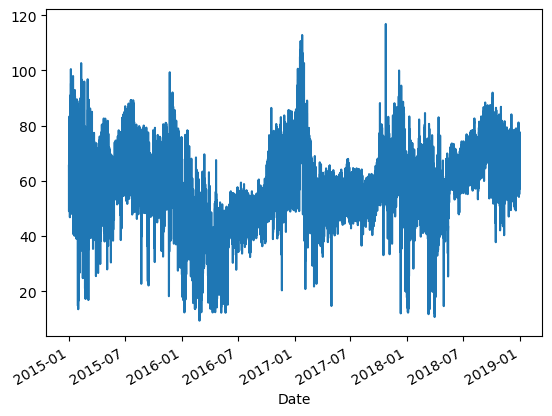

In [12]:
# Ploting our target column
Actual_Price.plot()

# Scale and Normalize Time Series Data for Further Modelling


In [12]:
Scaled_Actual_Price = energy_data['Actual_Price']/ energy_data['Actual_Price'].max()

<AxesSubplot:>

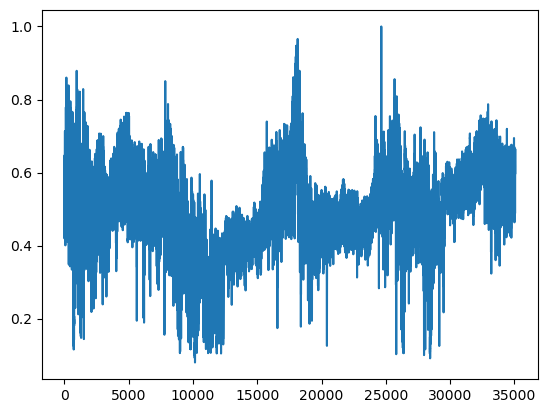

In [354]:
Scaled_Actual_Price.plot()


<AxesSubplot:>

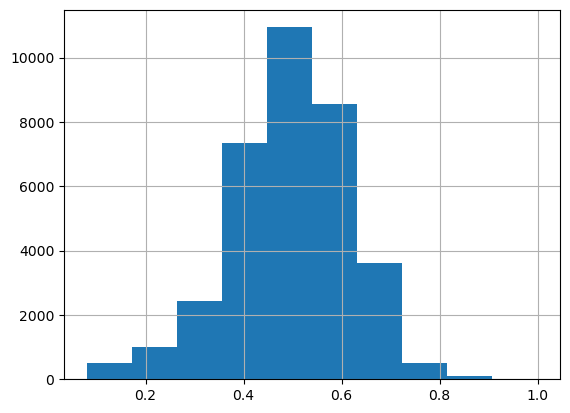

In [491]:
Scaled_Actual_Price .hist()

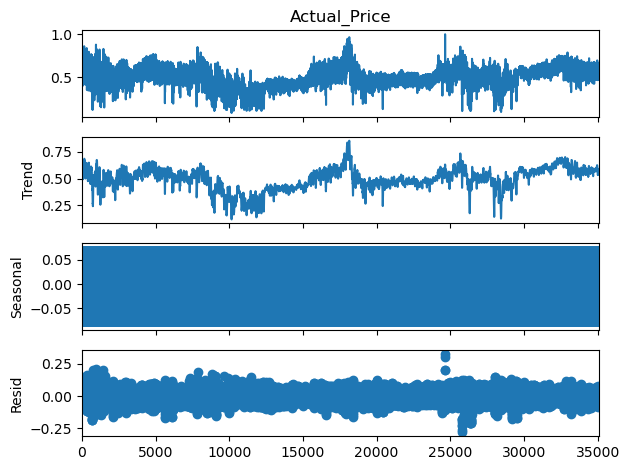

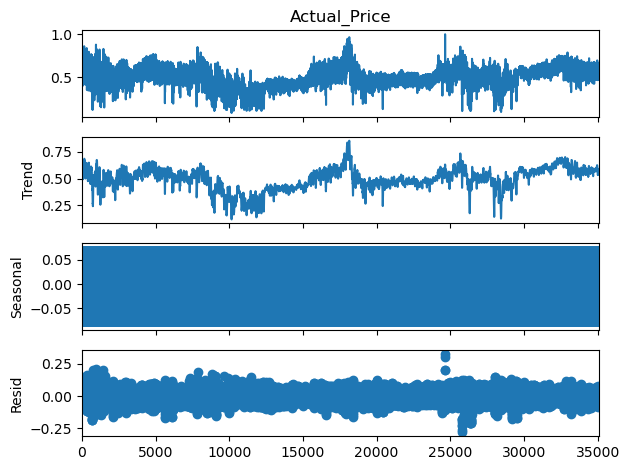

In [353]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(Scaled_Actual_Price, model='additive', period=24)
result.plot()


# Time-series Scaled_Actual_Price Data Stationary Check



### Automate the augmented Dickey-Fuller Test (Stationarity Test)


In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(Scaled_Actual_Price)

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.147016e+00
p-value                 2.750493e-15
# lags used             5.000000e+01
# observations          3.501300e+04
critical value (1%)    -3.430537e+00
critical value (5%)    -2.861623e+00
critical value (10%)   -2.566814e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [494]:
X = Scaled_Actual_Price.values
seq = round(len(X) / 2)
x1, x2 = X[0:seq], X[seq:]
meanx1, meanx2 = x1.mean(), x2.mean()
varx1, varx2 = x1.var(), x2.var()
print('meanx1=%f, meanx2=%f' % (meanx1, meanx2))
print('variancex1=%f, variancex2=%f' % (varx1, varx2))
# The mean and variances linger around each other, which clearly shows the data is invariant and hence, stationary

meanx1=0.465565, meanx2=0.525600
variancex1=0.016488, variancex2=0.011287


# Auto Regressive Moving Average (ARMA) Model for Time-Series Forecasting


## Visualization function for our predictions 

In [15]:
def plot_predictions(df_test, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(df_test, label='Actual')
    plt.plot(df_test.index, predictions, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('ARMA Model - Actual vs. Predicted (Test Set)')
    plt.legend()
    plt.show()

## Method 1 (y(t) = p(t)- p(t-1))

<AxesSubplot:xlabel='Date'>

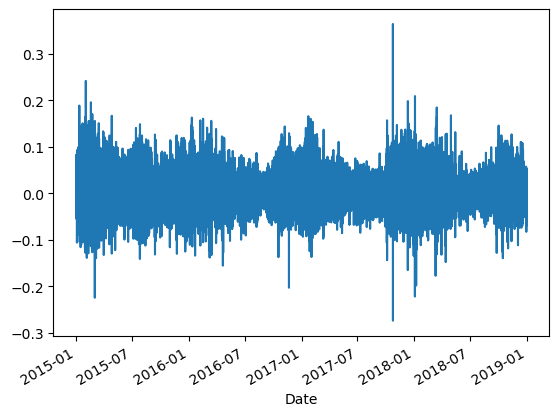

In [17]:
# differencing y(t) = p(t)- p(t-1)
diff1 = Scaled_Actual_Price.diff(1).dropna()
n = len(diff1)
train_energy1 = diff1[:int(n*2/3)]
test_energy1 = diff1[int(n*2/3):]
diff1.plot()

In [498]:
diff1.head(5)

Date
2015-01-01 01:00:00+01:00   -0.004195
2015-01-01 02:00:00+01:00   -0.003767
2015-01-01 03:00:00+01:00   -0.044178
2015-01-01 04:00:00+01:00   -0.028082
2015-01-01 05:00:00+01:00   -0.020634
Name: Actual_Price, dtype: float64


In this first section we'll look at a stationary dataset, determine (p,q) orders.

In [500]:
# ARMA(1,1) Model
model_arma_1_1= sm.tsa.arima.ARIMA(train_energy1, order=(1,0,1))
results_arma_1_1 = model_arma_1_1.fit()
results_arma_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23375
Model:                 ARIMA(1, 0, 1)   Log Likelihood               50749.297
Date:                Sun, 23 Jul 2023   AIC                        -101490.594
Time:                        16:20:02   BIC                        -101458.356
Sample:                             0   HQIC                       -101480.126
                              - 23375                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.246e-06      0.000     -0.015      0.988      -0.001       0.001
ar.L1          0.4064      0.010     39.934      0.000       0.386       0.426
ma.L1          0.1186      0.011     11.060      0.000       0.098       0.140
sigma2         0.0008   4.21e-06    180.718      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):             12973.49
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

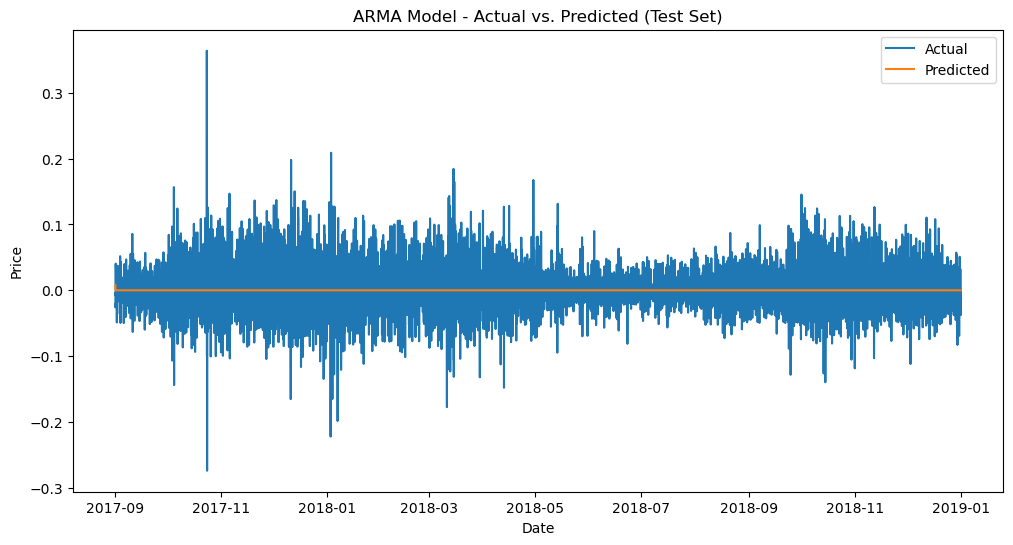

In [501]:
predictions1 = results_arma_1_1.predict(start=len(train_energy1), end=len(train_energy1) +len(test_energy1) - 1)
plot_predictions(test_energy1, predictions1)


In [101]:
# ARMA(3,1) Model
model_arma_3_1= sm.tsa.arima.ARIMA(train_energy1, order=(3,0,1))
results_arma_3_1 = model_arma_3_1.fit()
results_arma_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23375
Model:                 ARIMA(3, 0, 1)   Log Likelihood               51846.348
Date:                Thu, 20 Jul 2023   AIC                        -103680.696
Time:                        12:23:32   BIC                        -103632.339
Sample:                             0   HQIC                       -103664.994
                              - 23375                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.000     -7.609      0.000      -0.001      -0.001
ar.L1          1.2580      0.009    137.001      0.000       1.240       1.276
ar.L2         -0.3379      0.009    -38.133      0.000      -0.355      -0.321
ar.L3         -0.1135      0.006    -20.310      0.000      -0.124      -0.103
ma.L1         -0.8461      0.008   -103.258      0.000      -0.862      -0.830
sigma2         0.0006   3.54e-06    181.859      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   7.46   Jarque-Bera (JB):             13717.84
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

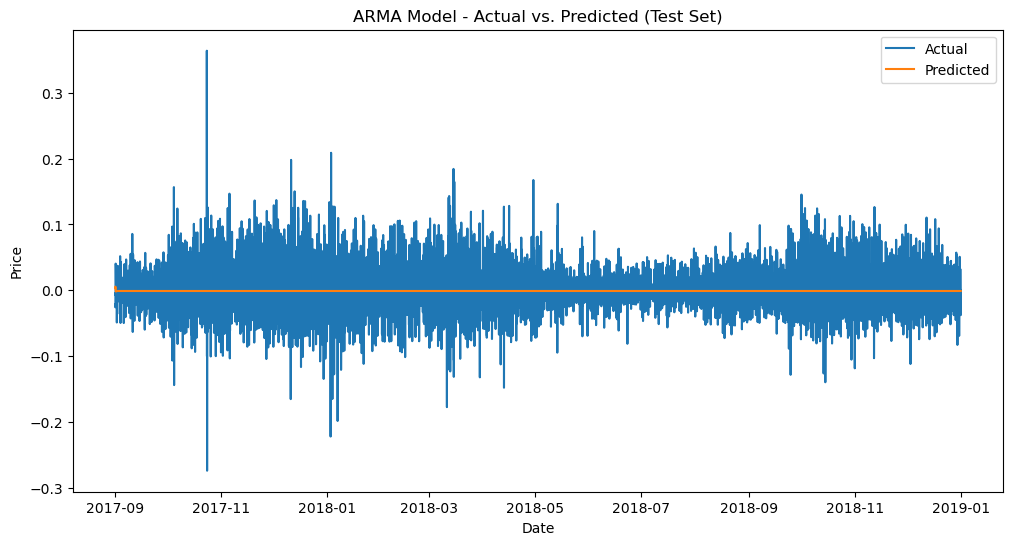

In [102]:
predictions2 = results_arma_3_1.predict(start=len(train_energy1), end=len(train_energy1) +len(test_energy1) - 1)
plot_predictions(test_energy1, predictions2)

In [103]:
# ARMA(5,1) Model
model_arma_5_1= sm.tsa.arima.ARIMA(train_energy1, order=(5,0,1))
results_arma_5_1 = model_arma_5_1.fit()
results_arma_5_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23375
Model:                 ARIMA(5, 0, 1)   Log Likelihood               51496.917
Date:                Thu, 20 Jul 2023   AIC                        -102977.833
Time:                        12:24:15   BIC                        -102913.358
Sample:                             0   HQIC                       -102956.897
                              - 23375                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.761      0.447      -0.000       0.001
ar.L1          0.3565      0.047      7.569      0.000       0.264       0.449
ar.L2          0.0288      0.022      1.289      0.198      -0.015       0.073
ar.L3         -0.0595      0.006     -9.467      0.000      -0.072      -0.047
ar.L4         -0.0904      0.007    -12.798      0.000      -0.104      -0.077
ar.L5         -0.1412      0.009    -15.958      0.000      -0.159      -0.124
ma.L1          0.0819      0.048      1.710      0.087      -0.012       0.176
sigma2         0.0007   4.38e-06    165.677      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  11.17   Jarque-Bera (JB):             12571.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

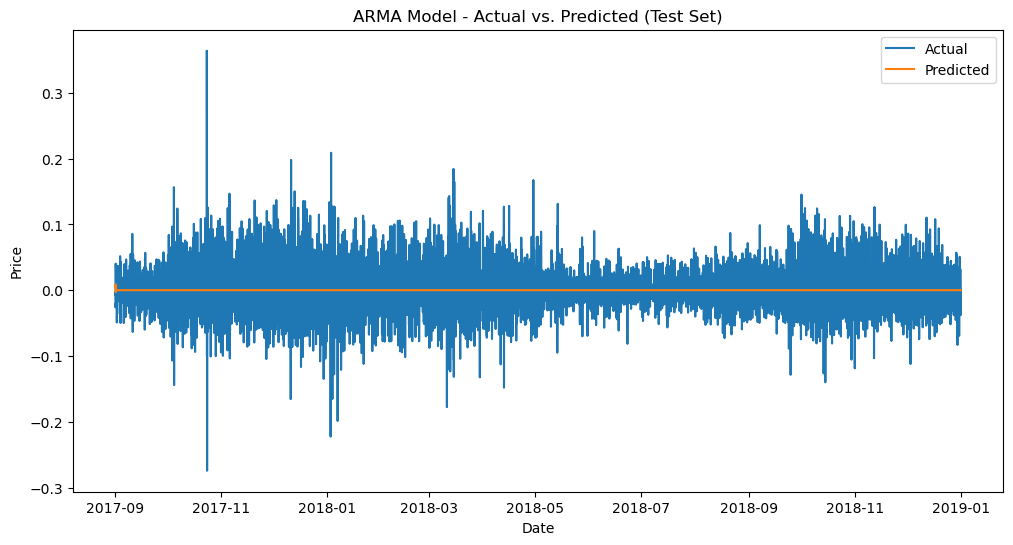

In [104]:
predictions3 = results_arma_5_1.predict(start=len(train_energy1), end=len(train_energy1) +len(test_energy1) - 1)
plot_predictions(test_energy1, predictions3)

In [110]:
# ARMA(10,1) Model
model_arma_10_1= sm.tsa.arima.ARIMA(train_energy1, order=(10,0,1))
results_arma_10_1 = model_arma_10_1.fit()
results_arma_10_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23375
Model:                ARIMA(10, 0, 1)   Log Likelihood               52154.249
Date:                Thu, 20 Jul 2023   AIC                        -104282.499
Time:                        12:26:54   BIC                        -104177.726
Sample:                             0   HQIC                       -104248.477
                              - 23375                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.585e-05      0.000     -0.106      0.915      -0.000       0.000
ar.L1          0.1466      0.274      0.535      0.592      -0.390       0.683
ar.L2          0.0574      0.115      0.499      0.618      -0.168       0.283
ar.L3         -0.0702      0.017     -4.204      0.000      -0.103      -0.037
ar.L4         -0.1203      0.016     -7.300      0.000      -0.153      -0.088
ar.L5         -0.1295      0.030     -4.321      0.000      -0.188      -0.071
ar.L6         -0.1264      0.029     -4.427      0.000      -0.182      -0.070
ar.L7         -0.1368      0.028     -4.848      0.000      -0.192      -0.081
ar.L8         -0.0652      0.031     -2.133      0.033      -0.125      -0.005
ar.L9         -0.0667      0.011     -6.033      0.000      -0.088      -0.045
ar.L10         0.0057      0.016      0.361      0.718      -0.025       0.036
ma.L1          0.2741      0.274      1.002      0.316      -0.262       0.810
sigma2         0.0007   3.97e-06    169.914      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12308.08
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

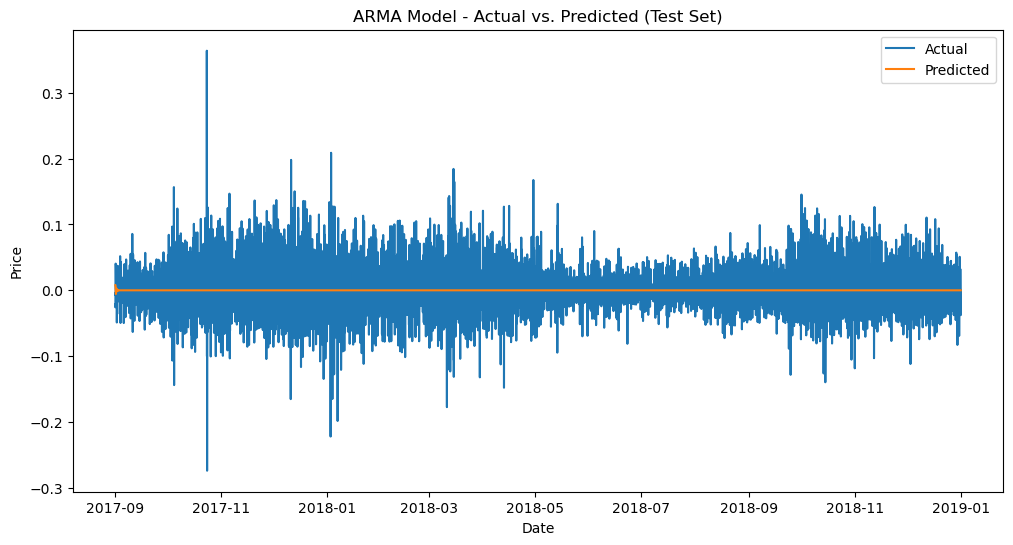

In [111]:
predictions4 = results_arma_10_1.predict(start=len(train_energy1), end=len(train_energy1) +len(test_energy1) - 1)
plot_predictions(test_energy1, predictions4)

## Method 2 (differencing y(t) = log((p(t) / p(t-1)))

<AxesSubplot:xlabel='Date'>

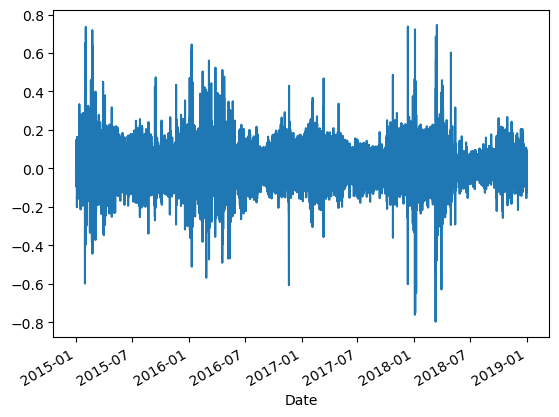

In [502]:
# differencing y(t) = log((p(t) / p(t-1))
diff2 = (np.log(Scaled_Actual_Price/ Scaled_Actual_Price.shift(1))).dropna()
n = len(diff2)
train_energy2 = diff2[:int(n*2/3)]
test_energy2 = diff2[int(n*2/3):]
diff2.plot()

In [503]:
# ARMA(1,1) Model
model_arma_1_1= sm.tsa.arima.ARIMA(train_energy2, order=(1,0,1))
results_arma_1_1 = model_arma_1_1.fit()
results_arma_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23375
Model:                 ARIMA(1, 0, 1)   Log Likelihood               30664.336
Date:                Sun, 23 Jul 2023   AIC                         -61320.673
Time:                        16:20:31   BIC                         -61288.435
Sample:                             0   HQIC                        -61310.205
                              - 23375                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.25e-05      0.001     -0.015      0.988      -0.002       0.002
ar.L1          0.4375      0.008     51.883      0.000       0.421       0.454
ma.L1          0.0657      0.009      7.435      0.000       0.048       0.083
sigma2         0.0042   1.74e-05    244.544      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):             73815.12
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

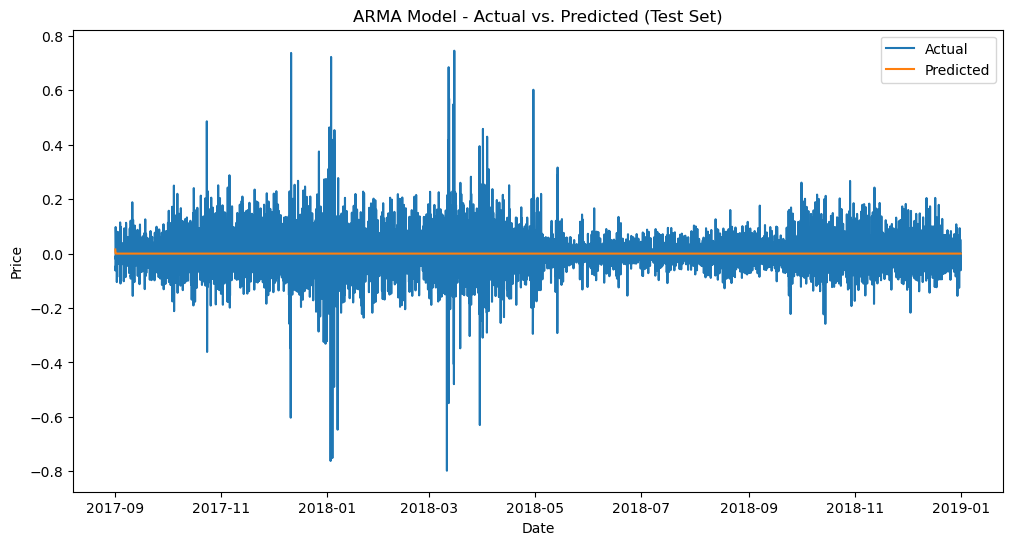

In [380]:
predictions5 = results_arma_1_1.predict(start=len(train_energy2), end=len(train_energy2) + len(test_energy2) - 1)
plot_predictions(test_energy2, predictions5)

In [115]:
# ARMA(3,1) Model
model_arma_3_1= sm.tsa.arima.ARIMA(train_energy2, order=(3,0,1))
results_arma_3_1 = model_arma_3_1.fit()
results_arma_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23376
Model:                 ARIMA(3, 0, 1)   Log Likelihood               32062.307
Date:                Thu, 20 Jul 2023   AIC                         -64112.615
Time:                        12:27:36   BIC                         -64064.258
Sample:                             0   HQIC                        -64096.912
                              - 23376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.482e-06      0.000     -0.051      0.960      -0.000       0.000
ar.L1          1.3078      0.005    282.448      0.000       1.299       1.317
ar.L2         -0.3699      0.007    -55.785      0.000      -0.383      -0.357
ar.L3         -0.1339      0.005    -29.615      0.000      -0.143      -0.125
ma.L1         -0.9117      0.003   -329.159      0.000      -0.917      -0.906
sigma2         0.0038   1.59e-05    237.076      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             67836.06
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

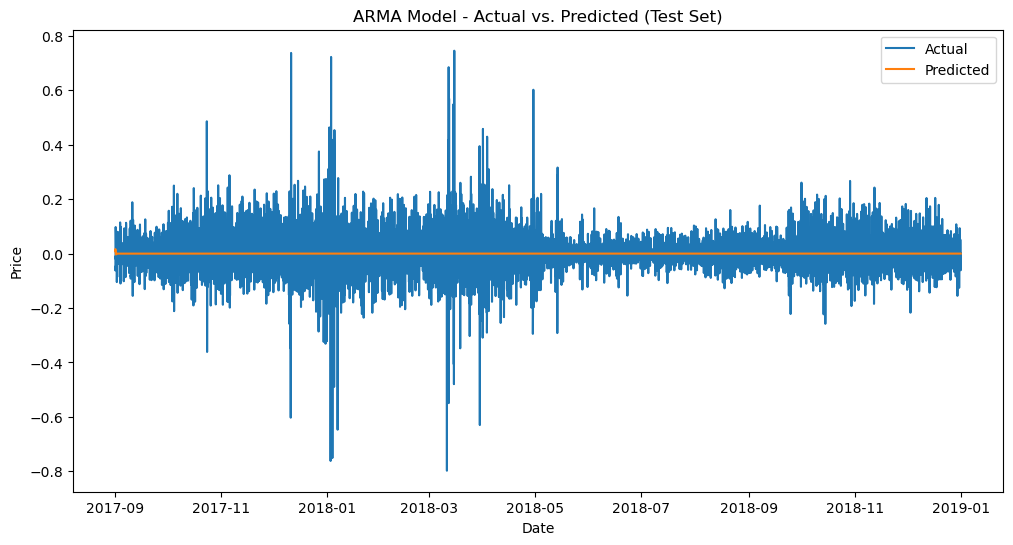

In [116]:
predictions6 = results_arma_3_1.predict(start=len(train_energy2), end=len(train_energy2) + len(test_energy2) - 1)
plot_predictions(test_energy2, predictions6)

In [117]:
# ARMA(5,1) Model
model_arma_5_1= sm.tsa.arima.ARIMA(train_energy2, order=(5,0,1))
results_arma_5_1 = model_arma_5_1.fit()
results_arma_5_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23376
Model:                 ARIMA(5, 0, 1)   Log Likelihood               32077.455
Date:                Thu, 20 Jul 2023   AIC                         -64138.910
Time:                        12:28:16   BIC                         -64074.434
Sample:                             0   HQIC                        -64117.973
                              - 23376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.344      0.731      -0.001       0.001
ar.L1          1.0616      0.012     91.046      0.000       1.039       1.084
ar.L2         -0.2863      0.008    -36.489      0.000      -0.302      -0.271
ar.L3         -0.0417      0.007     -5.952      0.000      -0.055      -0.028
ar.L4         -0.0620      0.007     -8.622      0.000      -0.076      -0.048
ar.L5         -0.0896      0.006    -14.519      0.000      -0.102      -0.077
ma.L1         -0.6652      0.011    -59.928      0.000      -0.687      -0.643
sigma2         0.0038    1.6e-05    235.602      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             70400.25
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

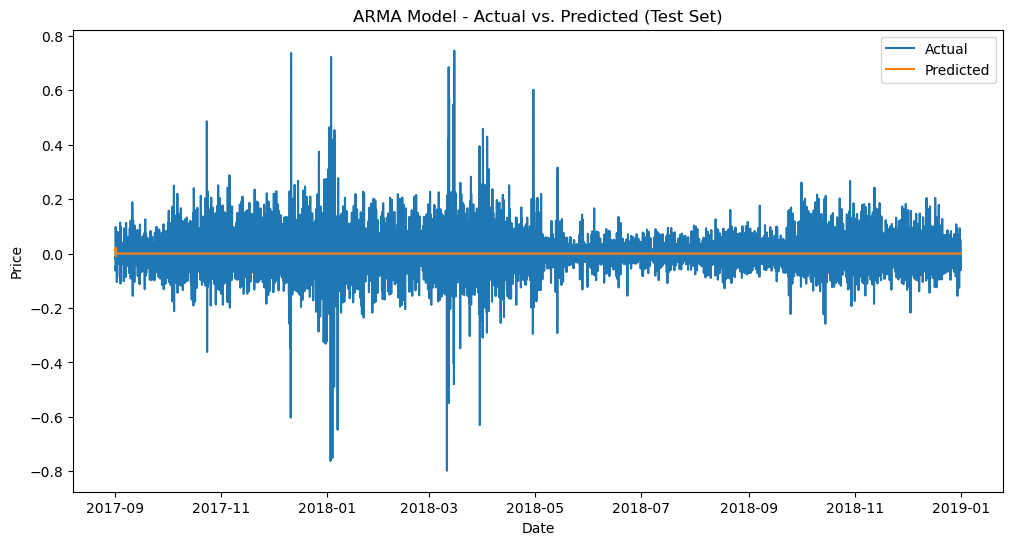

In [118]:
predictions7 = results_arma_5_1.predict(start=len(train_energy2), end=len(train_energy2) + len(test_energy2) - 1)
plot_predictions(test_energy2, predictions7)

In [504]:
# ARMA(10,1) Model
model_arma_10_1= sm.tsa.arima.ARIMA(train_energy2, order=(10,0,1))
results_arma_10_1 = model_arma_10_1.fit()
results_arma_10_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23375
Model:                ARIMA(10, 0, 1)   Log Likelihood               32215.327
Date:                Sun, 23 Jul 2023   AIC                         -64404.654
Time:                        16:22:11   BIC                         -64299.882
Sample:                             0   HQIC                        -64370.633
                              - 23375                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.591e-05      0.000     -0.044      0.965      -0.001       0.001
ar.L1          0.7080      0.071      9.920      0.000       0.568       0.848
ar.L2         -0.1454      0.028     -5.114      0.000      -0.201      -0.090
ar.L3         -0.0563      0.006     -9.351      0.000      -0.068      -0.045
ar.L4         -0.0673      0.008     -8.943      0.000      -0.082      -0.053
ar.L5         -0.0880      0.009    -10.022      0.000      -0.105      -0.071
ar.L6         -0.0529      0.010     -5.540      0.000      -0.072      -0.034
ar.L7         -0.0738      0.009     -8.069      0.000      -0.092      -0.056
ar.L8         -0.0183      0.010     -1.883      0.060      -0.037       0.001
ar.L9         -0.0546      0.008     -7.188      0.000      -0.069      -0.040
ar.L10         0.0768      0.005     14.221      0.000       0.066       0.087
ma.L1         -0.3161      0.072     -4.407      0.000      -0.457      -0.175
sigma2         0.0037   1.64e-05    226.954      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):             68380.63
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

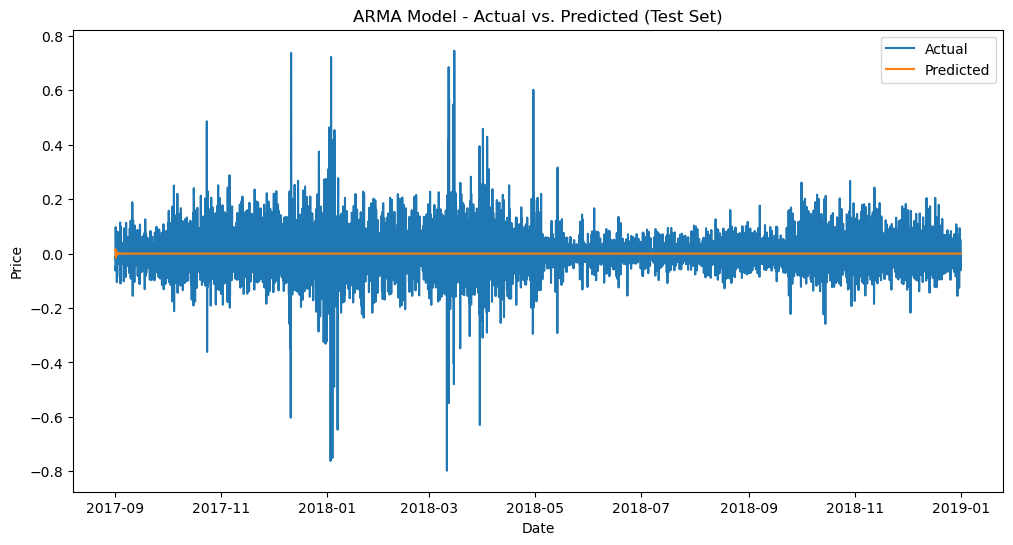

In [120]:
predictions8 = results_arma_10_1.predict(start=len(train_energy2), end=len(train_energy2) + len(test_energy2) - 1)
plot_predictions(test_energy2, predictions8)

## Method 3 differencing y(t) = (p(t) - p(t-1))/ p(t-1)

<AxesSubplot:xlabel='Date'>

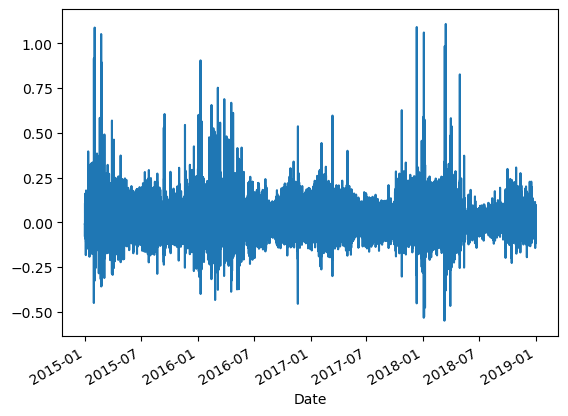

In [506]:
# differencing y(t) = (p(t) - p(t-1))/ p(t-1)

diff3 = ((Scaled_Actual_Price - Scaled_Actual_Price .shift(1)) / (Scaled_Actual_Price .shift(1))).dropna()
n = len(diff3)
train_energy3 = diff3[:int(n*2/3)]
test_energy3 = diff3[int(n*2/3):]
diff3.plot()




In [383]:
diff3.head()

Date
2015-01-01 01:00:00+01:00   -0.007491
2015-01-01 02:00:00+01:00   -0.006778
2015-01-01 03:00:00+01:00   -0.080025
2015-01-01 04:00:00+01:00   -0.055293
2015-01-01 05:00:00+01:00   -0.043005
Name: Actual_Price, dtype: float64

In [507]:
# ARMA(1,1) Model
model_arma_1_1= sm.tsa.arima.ARIMA(train_energy3, order=(1,0,1))
results_arma_1_1 = model_arma_1_1.fit()
results_arma_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23375
Model:                 ARIMA(1, 0, 1)   Log Likelihood               29689.709
Date:                Sun, 23 Jul 2023   AIC                         -59371.417
Time:                        16:22:27   BIC                         -59339.179
Sample:                             0   HQIC                        -59360.949
                              - 23375                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.081      0.002       0.001       0.005
ar.L1          0.4226      0.008     49.845      0.000       0.406       0.439
ma.L1          0.0760      0.009      8.537      0.000       0.059       0.094
sigma2         0.0046   1.49e-05    310.312      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):            293581.55
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

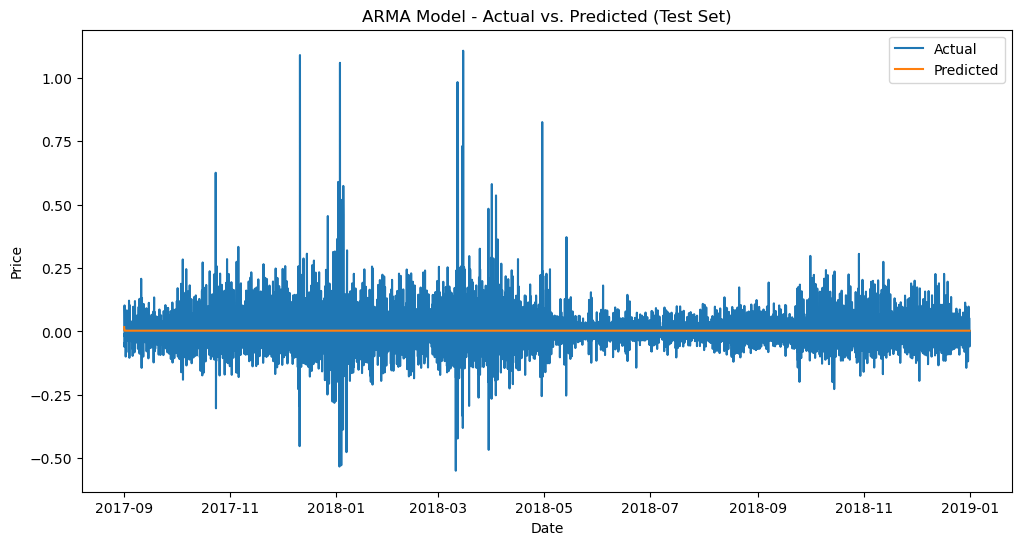

In [508]:
predictions9 = results_arma_1_1.predict(start=len(train_energy3), end=len(train_energy3) + len(test_energy3) - 1)
plot_predictions(test_energy3, predictions9)

In [125]:
# ARMA(3,1) Model
model_arma_3_1= sm.tsa.arima.ARIMA(train_energy3, order=(3,0,1))
results_arma_3_1 = model_arma_3_1.fit()
results_arma_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23376
Model:                 ARIMA(3, 0, 1)   Log Likelihood               30919.690
Date:                Thu, 20 Jul 2023   AIC                         -61827.381
Time:                        12:30:19   BIC                         -61779.024
Sample:                             0   HQIC                        -61811.679
                              - 23376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.000     10.244      0.000       0.002       0.003
ar.L1          1.2831      0.005    237.918      0.000       1.273       1.294
ar.L2         -0.3625      0.007    -53.326      0.000      -0.376      -0.349
ar.L3         -0.1340      0.005    -28.631      0.000      -0.143      -0.125
ma.L1         -0.8728      0.004   -223.995      0.000      -0.880      -0.865
sigma2         0.0042   1.36e-05    306.379      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):            315201.46
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

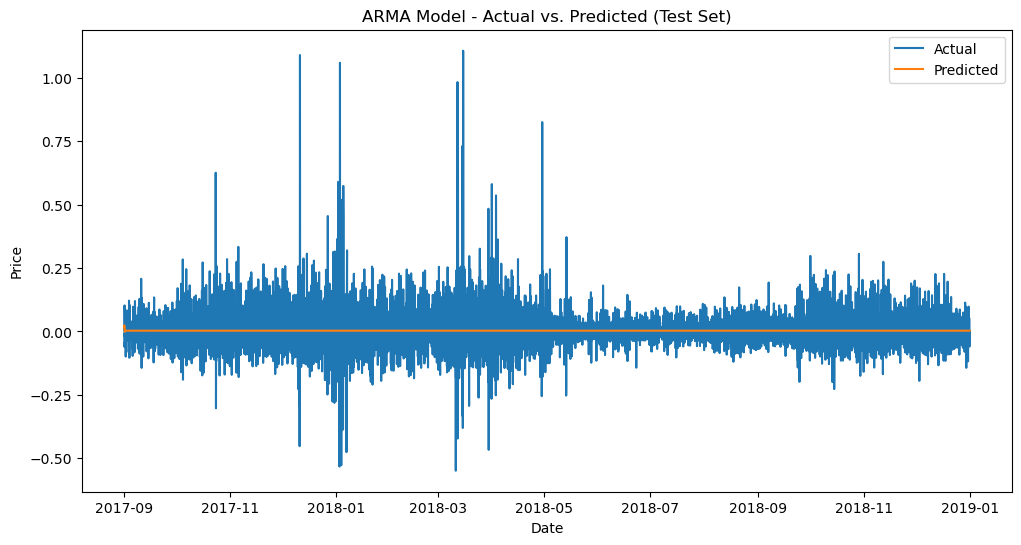

In [126]:
predictions10 = results_arma_3_1.predict(start=len(train_energy3), end=len(train_energy3) + len(test_energy3) - 1)

plot_predictions(test_energy3, predictions10)

In [127]:
# ARMA(5,1) Model
model_arma_5_1= sm.tsa.arima.ARIMA(train_energy3, order=(5,0,1))
results_arma_5_1 = model_arma_5_1.fit()
results_arma_5_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23376
Model:                 ARIMA(5, 0, 1)   Log Likelihood               31002.991
Date:                Thu, 20 Jul 2023   AIC                         -61989.982
Time:                        12:31:01   BIC                         -61925.506
Sample:                             0   HQIC                        -61969.045
                              - 23376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.000      8.356      0.000       0.002       0.003
ar.L1          1.1300      0.009    120.297      0.000       1.112       1.148
ar.L2         -0.3013      0.007    -41.530      0.000      -0.316      -0.287
ar.L3         -0.0623      0.007     -8.689      0.000      -0.076      -0.048
ar.L4         -0.0481      0.007     -6.531      0.000      -0.063      -0.034
ar.L5         -0.0642      0.006    -11.062      0.000      -0.076      -0.053
ma.L1         -0.7457      0.008    -87.871      0.000      -0.762      -0.729
sigma2         0.0041   1.32e-05    308.522      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   5.16   Jarque-Bera (JB):            323902.69
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

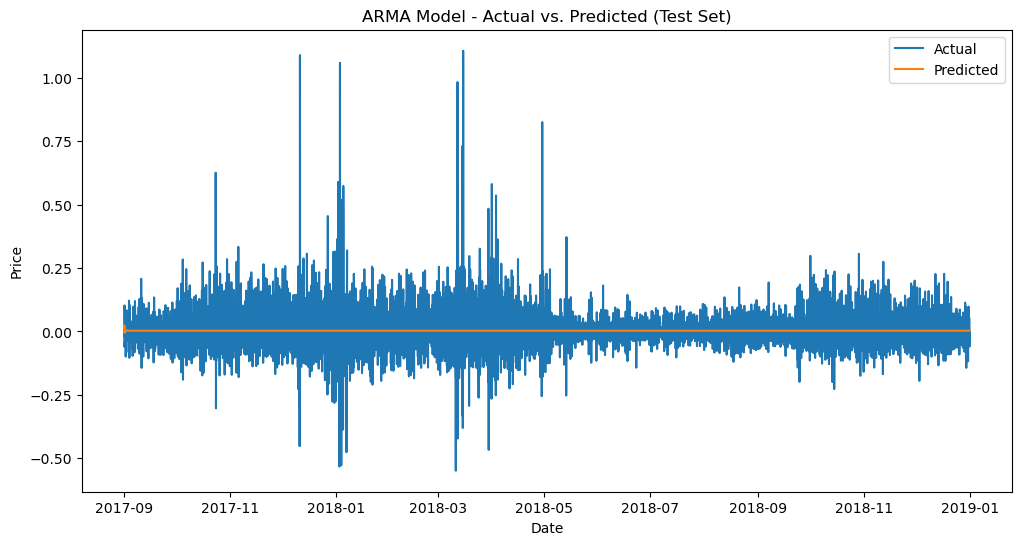

In [128]:
predictions11 = results_arma_5_1.predict(start=len(train_energy3), end=len(train_energy3) + len(test_energy3) - 1)
plot_predictions(test_energy3, predictions11)

In [129]:
# ARMA(10,1) Model 
model_arma_10_1= sm.tsa.arima.ARIMA(train_energy3, order=(10,0,1))
results_arma_10_1 = model_arma_10_1.fit()
results_arma_10_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Actual_Price   No. Observations:                23376
Model:                ARIMA(10, 0, 1)   Log Likelihood               31138.099
Date:                Thu, 20 Jul 2023   AIC                         -62250.198
Time:                        12:32:16   BIC                         -62145.425
Sample:                             0   HQIC                        -62216.177
                              - 23376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.000      7.362      0.000       0.002       0.004
ar.L1          0.2724      0.116      2.348      0.019       0.045       0.500
ar.L2          0.0219      0.046      0.479      0.632      -0.068       0.111
ar.L3         -0.0631      0.006    -10.633      0.000      -0.075      -0.051
ar.L4         -0.1009      0.009    -11.484      0.000      -0.118      -0.084
ar.L5         -0.1185      0.012     -9.599      0.000      -0.143      -0.094
ar.L6         -0.1148      0.013     -8.933      0.000      -0.140      -0.090
ar.L7         -0.1273      0.013     -9.434      0.000      -0.154      -0.101
ar.L8         -0.0655      0.014     -4.593      0.000      -0.093      -0.038
ar.L9         -0.0432      0.008     -5.474      0.000      -0.059      -0.028
ar.L10         0.0376      0.006      6.478      0.000       0.026       0.049
ma.L1          0.1197      0.116      1.033      0.302      -0.107       0.347
sigma2         0.0041   1.41e-05    288.496      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            311093.43
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

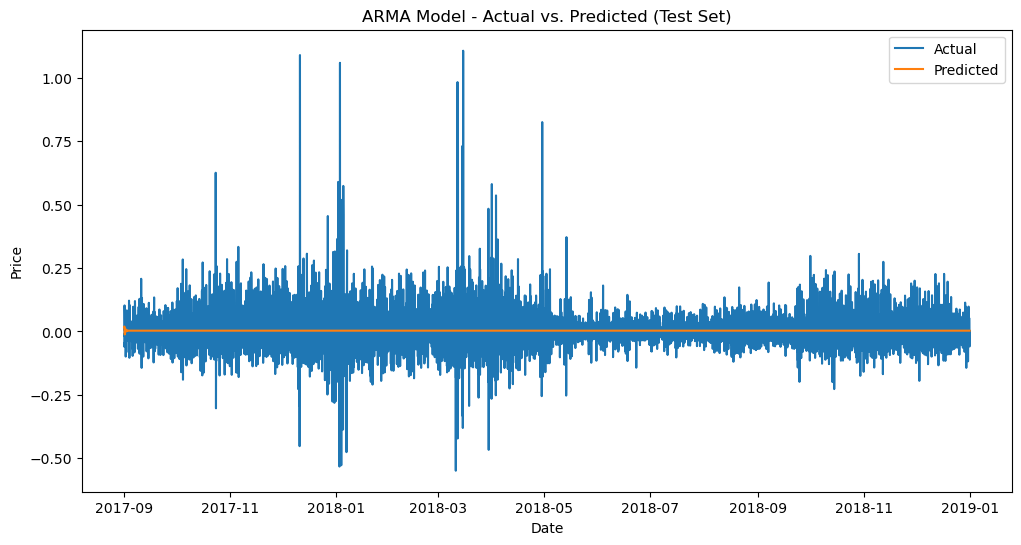

In [130]:
predictions12 = results_arma_10_1.predict(start=len(train_energy3), end=len(train_energy3) + len(test_energy3) - 1)
plot_predictions(test_energy3, predictions12)

In [18]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# Function to calculate NMSE
def calculate_nmse(true_values, predictions):
    true_values = np.array(true_values)
    predictions = np.array(predictions)

    mse = np.mean((true_values - predictions) ** 2)
    # Normalize the MSE by dividing by the variance of the true values
    nmse = mse / np.var(true_values) 
    return nmse

# Initialize an empty dataframe to store the NMSE values
nmse_values = pd.DataFrame(columns=['ARMA(1,1) NMSE', 'ARMA(3,1) NMSE', 'ARMA(5,1) NMSE', 'ARMA(10,1) NMSE'],  index=['y(t) = p(t)- p(t-1)', 'y(t) = log((p(t) / p(t-1))', 'y(t) = (p(t) - p(t-1))/ p(t-1)'])

# Define your actual values
true_values = [test_energy1, test_energy2, test_energy3]

for i in range(3):  # Iterate over the 3 test sets
    for j in range(1, 5):  # Iterate over the 4 predictions for each test set
        # Get the predictions
        predictions = globals()['predictions' + str((i * 4) + j)]
        # Calculate the NMSE
        nmse = calculate_nmse(true_values[i], predictions)
        # Store the NMSE in the dataframe
        nmse_values.iloc[i, j - 1] = nmse
html_table = nmse_values.to_html()

display(HTML(html_table))



NameError: name 'test_energy2' is not defined

# MLP Algorithm 

In [13]:
Scaled_Actual_Price = energy_data['Actual_Price']/ energy_data['Actual_Price'].max()
# Assuming Scaled_Actual_Price is your DataFrame
# Split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
# Define input sequence
# Choose a number of time steps
n_steps = 2
# Split into samples
X, y = split_sequence(Scaled_Actual_Price, n_steps)
# Combine X and y into a single DataFrame
data = np.column_stack((X, y))
columns = [f"X_{i+1}" for i in range(n_steps)] + ['y']
df = pd.DataFrame(data, columns=columns)
# Now, 'df' is the DataFrame containing both X and y as columns.
print(df)


            X_1       X_2         y
0      0.560017  0.555822  0.552055
1      0.555822  0.552055  0.507877
2      0.552055  0.507877  0.479795
3      0.507877  0.479795  0.459161
4      0.479795  0.459161  0.442894
...         ...       ...       ...
35057  0.643236  0.664469  0.659418
35058  0.664469  0.659418  0.652055
35059  0.659418  0.652055  0.636130
35060  0.652055  0.636130  0.598373
35061  0.636130  0.598373  0.598288

[35062 rows x 3 columns]


In [75]:
# preprocessing the data for MLP model
Actual_Price=energy_data[['Actual_Price']] / energy_data[['Actual_Price']].max()

# create Date column
Actual_Price['Date']=Actual_Price.index
Actual_Price=Actual_Price.reset_index(drop=True) 
Actual_Price['Date']=pd.to_datetime(Actual_Price['Date'],utc=True)

# Use cyclical encoding method for time series Date
Actual_Price['hour']=Actual_Price['Date'].dt.hour
Actual_Price['hour_sin']=np.sin(2*np.pi*Actual_Price['hour']/24)
Actual_Price['hour_cos']=np.cos(2*np.pi*Actual_Price['hour']/24)
Actual_Price

,Actual_Price,Date,hour,hour_sin,hour_cos
0,0.560017,2014-12-31 23:00:00+00:00,23,-0.258819,9.659258e-01
1,0.555822,2015-01-01 00:00:00+00:00,0,0.000000,1.000000e+00
2,0.552055,2015-01-01 01:00:00+00:00,1,0.258819,9.659258e-01
3,0.507877,2015-01-01 02:00:00+00:00,2,0.500000,8.660254e-01
4,0.479795,2015-01-01 03:00:00+00:00,3,0.707107,7.071068e-01
...,...,...,...,...,...
35059,0.659418,2018-12-31 18:00:00+00:00,18,-1.000000,-1.836970e-16
35060,0.652055,2018-12-31 19:00:00+00:00,19,-0.965926,2.588190e-01
35061,0.636130,2018-12-31 20:00:00+00:00,20,-0.866025,5.000000e-01
35062,0.598373,2018-12-31 21:00:00+00:00,21,-0.707107,7.071068e-01


In [72]:
# Separate features and target
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
Y = Actual_Price['Actual_Price'].values

## mlp from scratch

In [157]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(40)  # Set the random seed for reproducibility

class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            # Using Xavier/Glorot initialization for sigmoid activation
            weight = np.random.normal(0, np.sqrt(1 / self.layers[i]), 
                                      (self.layers[i], self.layers[i + 1]))
            bias = np.zeros(self.layers[i + 1])
            self.weights.append(weight)
            self.biases.append(bias)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_pass(self, inputs):
        self.activation_outputs = [inputs]
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            self.activation_outputs.append(inputs)
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        self.activation_outputs.append(outputs)
        return outputs

    def mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        return np.mean((actual - predicted)**2)

    def normalized_mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        variance = np.var(actual)
        mse = self.mean_squared_error_loss(actual)
        return mse / variance

    def validate(self, inputs, labels):
        outputs = self.forward_pass(inputs)
        loss = self.normalized_mean_squared_error_loss(labels)
        return loss

    def backpropagation(self, actual, learning_rate):
        output_error = actual - self.activation_outputs[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.sigmoid_derivative(self.activation_outputs[i])
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            weight_gradient = np.dot(self.activation_outputs[i].T, deltas[i])
            bias_gradient = np.sum(deltas[i], axis=0)
            
            self.weights[i] += weight_gradient * learning_rate
            self.biases[i] += bias_gradient * learning_rate

    def train(self, inputs, labels, X_val, y_val, num_epochs, learning_rate):
        # Create lists to store loss values
        self.training_losses = []
        self.validation_losses = []
        self.training_nmse_losses = []  # List to store NMSE values for training

        for epoch in range(num_epochs):
            for input_val, label in zip(inputs, labels):
                self.forward_pass(input_val.reshape(1, -1))  
                self.backpropagation(label.reshape(1, -1), learning_rate)
        
            train_loss = self.mean_squared_error_loss(labels)
            train_nmse_loss = self.normalized_mean_squared_error_loss(labels)  # Compute NMSE for training
            val_loss = self.validate(X_val, y_val)
            
            # Record the losses
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.training_nmse_losses.append(train_nmse_loss)  # Record the training NMSE
            
            print(f'Epoch: {epoch}, Training Loss (NMSE): {train_nmse_loss}, Validation Loss (NMSE): {val_loss}')


def plot_losses(mlp_model):
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation loss
    plt.plot(mlp_model.training_nmse_losses, label="Training NMSE Loss")  # Plot the training NMSE
    plt.plot(mlp_model.validation_losses, label="Validation NMSE Loss")
    
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()


In [168]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(40)  # Set the random seed for reproducibility

class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            # Using Xavier/Glorot initialization for sigmoid activation
            weight = np.random.normal(0, np.sqrt(1 / self.layers[i]), 
                                      (self.layers[i], self.layers[i + 1]))
            bias = np.zeros(self.layers[i + 1])
            self.weights.append(weight)
            self.biases.append(bias)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_pass(self, inputs):
        self.activation_outputs = [inputs]
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            self.activation_outputs.append(inputs)
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        self.activation_outputs.append(outputs)
        return outputs

    def mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        return np.mean((actual - predicted)**2)

    def normalized_mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        variance = np.var(actual)
        mse = self.mean_squared_error_loss(actual)
        return mse / variance

    def validate(self, inputs, labels):
        outputs = self.forward_pass(inputs)
        loss = self.normalized_mean_squared_error_loss(labels)
        return loss

    def backpropagation(self, actual, learning_rate):
        output_error = actual - self.activation_outputs[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.sigmoid_derivative(self.activation_outputs[i])
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            weight_gradient = np.dot(self.activation_outputs[i].T, deltas[i])
            bias_gradient = np.sum(deltas[i], axis=0)
            
            self.weights[i] += weight_gradient * learning_rate
            self.biases[i] += bias_gradient * learning_rate

    def train(self, inputs, labels, val_ratio, test_ratio, num_epochs, learning_rate):
        X_train, test_x, y_train, test_y = train_test_split(inputs, labels, test_size=test_ratio)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio)
        
        # Create lists to store loss values
        self.training_losses = []
        self.validation_losses = []
        self.training_nmse_losses = []  # List to store NMSE values for training

        for epoch in range(num_epochs):
            for input_val, label in zip(X_train, y_train):
                self.forward_pass(input_val.reshape(1, -1))  
                self.backpropagation(label.reshape(1, -1), learning_rate)
        
            train_loss = self.mean_squared_error_loss(y_train)
            train_nmse_loss = self.normalized_mean_squared_error_loss(y_train)  # Compute NMSE for training
            val_loss = self.validate(X_val, y_val)
            
            # Record the losses
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.training_nmse_losses.append(train_nmse_loss)  # Record the training NMSE
            
            print(f'Epoch: {epoch}, Training Loss (NMSE): {train_nmse_loss}, Validation Loss (NMSE): {val_loss}')


def plot_losses(mlp_model):
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation loss
    plt.plot(mlp_model.training_nmse_losses, label="Training NMSE Loss")  # Plot the training NMSE
    plt.plot(mlp_model.validation_losses, label="Validation NMSE Loss")
    
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()


In [285]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(40)  # Set the random seed for reproducibility

class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            weight = np.random.normal(0, np.sqrt(1 / self.layers[i]), 
                                      (self.layers[i], self.layers[i + 1]))
            bias = np.zeros(self.layers[i + 1])
            self.weights.append(weight)
            self.biases.append(bias)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_pass(self, inputs):
        self.activation_outputs = [inputs]
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            self.activation_outputs.append(inputs)
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        self.activation_outputs.append(outputs)
        return outputs

    def mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        return np.mean((actual - predicted)**2)

    def normalized_mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        variance = np.var(actual)
        mse = self.mean_squared_error_loss(actual)
        return mse / variance

    def validate(self, inputs, labels):
        outputs = self.forward_pass(inputs)
        loss = self.normalized_mean_squared_error_loss(labels)
        return loss

    def backpropagation(self, actual, learning_rate):
        output_error = actual - self.activation_outputs[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = self.sigmoid_derivative(self.activation_outputs[i]) * np.dot(deltas[0], self.weights[i].T)
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            weight_gradient = np.dot(self.activation_outputs[i].T, deltas[i])
            bias_gradient = np.sum(deltas[i], axis=0)
            
            self.weights[i] += weight_gradient * learning_rate
            self.biases[i] += bias_gradient * learning_rate

    def get_mini_batches(self, X, y, batch_size):
        random_indices = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            indices = random_indices[i:i+batch_size]
            yield X[indices], y[indices]
    
    def train(self, inputs, labels, val_ratio=1/3, test_ratio=1/3, num_epochs=55, learning_rate=0.001, batch_size=32):
        num_samples = len(inputs)
    
    # Calculate number of test samples
        num_test_samples = int(num_samples * test_ratio)
    
    # Deduct test samples from the dataset, and split the rest between training and validation
        num_train_val_samples = num_samples - num_test_samples
        num_val_samples = int(num_train_val_samples * val_ratio)
        num_train_samples = num_train_val_samples - num_val_samples

        indices = np.arange(num_samples)
        np.random.shuffle(indices)

    # Get indices for the test set
        test_indices = indices[:num_test_samples]
    
    # Indices for training and validation from the remaining samples
        train_indices = indices[num_test_samples:num_test_samples + num_train_samples]
        val_indices = indices[num_test_samples + num_train_samples:]

        X_train, X_val, X_test = inputs[train_indices], inputs[val_indices], inputs[test_indices]
        y_train, y_val, y_test = labels[train_indices], labels[val_indices], labels[test_indices]

        self.training_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.training_nmse_losses = []


        for epoch in range(num_epochs):
            for X_batch, y_batch in self.get_mini_batches(X_train, y_train, batch_size):
                self.forward_pass(X_batch)
                self.backpropagation(y_batch, learning_rate)

            # Forward pass with entire training data to compute the loss
            self.forward_pass(X_train)
            train_loss = self.mean_squared_error_loss(y_train)
            train_nmse_loss = self.normalized_mean_squared_error_loss(y_train)
            val_loss = self.validate(X_val, y_val)
            test_loss = self.validate(X_test, y_test)

            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.test_losses.append(test_loss)
            self.training_nmse_losses.append(train_nmse_loss)

            print(f'Epoch: {epoch}, Training Loss (NMSE): {train_nmse_loss}, Validation Loss (NMSE): {val_loss}, Test Loss (NMSE): {test_loss}')

def plot_losses(mlp_model):
    plt.figure(figsize=(10, 5))
    plt.plot(mlp_model.training_nmse_losses, label="Training NMSE Loss")
    plt.plot(mlp_model.validation_losses, label="Validation NMSE Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



In [371]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(40)  # Set the random seed for reproducibility

class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            weight = np.random.normal(0, np.sqrt(1 / self.layers[i]), 
                                      (self.layers[i], self.layers[i + 1]))
            bias = np.zeros(self.layers[i + 1])
            self.weights.append(weight)
            self.biases.append(bias)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_pass(self, inputs):
        self.activation_outputs = [inputs]
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            self.activation_outputs.append(inputs)
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        self.activation_outputs.append(outputs)
        return outputs

    def mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        return np.mean((actual - predicted)**2)

    def normalized_mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        variance = np.var(actual)
        mse = self.mean_squared_error_loss(actual)
        return mse / variance

    def validate(self, inputs, labels):
        outputs = self.forward_pass(inputs)
        loss = self.normalized_mean_squared_error_loss(labels)
        return loss

    def backpropagation(self, actual, learning_rate, clipvalue=1.0):
        output_error = actual - self.activation_outputs[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = self.sigmoid_derivative(self.activation_outputs[i]) * np.dot(deltas[0], self.weights[i].T)
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            weight_gradient = np.dot(self.activation_outputs[i].T, deltas[i])
            bias_gradient = np.sum(deltas[i], axis=0)

            # Clip gradients
            weight_gradient = np.clip(weight_gradient, -clipvalue, clipvalue)
            bias_gradient = np.clip(bias_gradient, -clipvalue, clipvalue)
            
            self.weights[i] += weight_gradient * learning_rate
            self.biases[i] += bias_gradient * learning_rate

    def get_mini_batches(self, X, y, batch_size):
        random_indices = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            indices = random_indices[i:i+batch_size]
            yield X[indices], y[indices]
    
    def train(self, inputs, labels, val_ratio=1/3, test_ratio=1/3, num_epochs=55, learning_rate=0.001, batch_size=32, clipvalue=1.0):
        num_samples = len(inputs)

    # Calculate the number of samples for test, validation, and training
        num_test_samples = int(num_samples * test_ratio)
        num_train_val_samples = num_samples - num_test_samples
        num_val_samples = int(num_train_val_samples * val_ratio)
        num_train_samples = num_train_val_samples - num_val_samples

    # Split the data chronologically
        X_train, X_val, X_test = inputs[:num_train_samples], inputs[num_train_samples:num_train_samples + num_val_samples], inputs[num_train_samples + num_val_samples:]
        y_train, y_val, y_test = labels[:num_train_samples], labels[num_train_samples:num_train_samples + num_val_samples], labels[num_train_samples + num_val_samples:]


        self.training_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.training_nmse_losses = []

        for epoch in range(num_epochs):
            for X_batch, y_batch in self.get_mini_batches(X_train, y_train, batch_size):
                self.forward_pass(X_batch)
                self.backpropagation(y_batch, learning_rate, clipvalue=clipvalue)

            self.forward_pass(X_train)
            train_loss = self.mean_squared_error_loss(y_train)
            train_nmse_loss = self.normalized_mean_squared_error_loss(y_train)
            val_loss = self.validate(X_val, y_val)
            test_loss = self.validate(X_test, y_test)

            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.test_losses.append(test_loss)
            self.training_nmse_losses.append(train_nmse_loss)

            print(f'Epoch: {epoch}, Training Loss (NMSE): {train_nmse_loss}, Validation Loss (NMSE): {val_loss}, Test Loss (NMSE): {test_loss}')


def plot_losses(mlp_model):
    plt.figure(figsize=(10, 5))
    plt.plot(mlp_model.training_nmse_losses, label="Training NMSE Loss")
    plt.plot(mlp_model.validation_losses, label="Validation NMSE Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Sample data processing (I assume you have the dataframe 'Actual_Price' loaded already)



In [63]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(40)  # Set the random seed for reproducibility

class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            weight = np.random.normal(0, np.sqrt(1 / self.layers[i]), 
                                      (self.layers[i], self.layers[i + 1]))
            bias = np.zeros(self.layers[i + 1])
            self.weights.append(weight)
            self.biases.append(bias)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_pass(self, inputs):
        self.activation_outputs = [inputs]
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            self.activation_outputs.append(inputs)
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        self.activation_outputs.append(outputs)
        return outputs
    def predict(self, inputs):
            for i in range(len(self.layers) - 2):
                inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
            return outputs
    def mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        return np.mean((actual - predicted)**2)

    def normalized_mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        variance = np.var(actual)
        mse = self.mean_squared_error_loss(actual)
        return mse / variance

    def validate(self, inputs, labels):
        outputs = self.forward_pass(inputs)
        loss = self.normalized_mean_squared_error_loss(labels)
        return loss

    def backpropagation(self, actual, learning_rate, clipvalue=1.0):
        output_error = actual - self.activation_outputs[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = self.sigmoid_derivative(self.activation_outputs[i]) * np.dot(deltas[0], self.weights[i].T)
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            weight_gradient = np.dot(self.activation_outputs[i].T, deltas[i])
            bias_gradient = np.sum(deltas[i], axis=0)

            # Clip gradients
            weight_gradient = np.clip(weight_gradient, -clipvalue, clipvalue)
            bias_gradient = np.clip(bias_gradient, -clipvalue, clipvalue)
            
            self.weights[i] += weight_gradient * learning_rate
            self.biases[i] += bias_gradient * learning_rate

    def get_mini_batches(self, X, y, batch_size):
        random_indices = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            indices = random_indices[i:i+batch_size]
            yield X[indices], y[indices]
    
    def train(self, inputs, labels, val_ratio=1/3, test_ratio=1/3, num_epochs=55, learning_rate=0.01, batch_size=32, clipvalue=1.0):
        num_samples = len(inputs)

    # Calculate the number of samples for test, training, and validation
        num_test_samples = int(num_samples * test_ratio)
        num_train_samples = num_samples - num_test_samples
        num_val_samples = int(num_train_samples * val_ratio)
        num_train_samples = num_train_samples - num_val_samples

    # Split the data chronologically
        X_train, X_val, X_test = inputs[:num_train_samples], inputs[num_train_samples:num_train_samples + num_val_samples], inputs[num_train_samples + num_val_samples:]
        y_train, y_val, y_test = labels[:num_train_samples], labels[num_train_samples:num_train_samples + num_val_samples], labels[num_train_samples + num_val_samples:]

        self.training_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.training_nmse_losses = []

        for epoch in range(num_epochs):
            for X_batch, y_batch in self.get_mini_batches(X_train, y_train, batch_size):
                self.forward_pass(X_batch)
                self.backpropagation(y_batch, learning_rate, clipvalue=clipvalue)

            self.forward_pass(X_train)
            train_loss = self.mean_squared_error_loss(y_train)
            train_nmse_loss = self.normalized_mean_squared_error_loss(y_train)
            val_loss = self.validate(X_val, y_val)
            test_loss = self.validate(X_test, y_test)

            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.test_losses.append(test_loss)
            self.training_nmse_losses.append(train_nmse_loss)

            print(f'Epoch: {epoch}, Training Loss (NMSE): {train_nmse_loss}, Validation Loss (NMSE): {val_loss}')

       
def plot_losses(mlp_model):
    plt.figure(figsize=(10, 5))
    plt.plot(mlp_model.training_nmse_losses, label="Training NMSE Loss")
    plt.plot(mlp_model.validation_losses, label="Validation NMSE Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [76]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(40)  # Set the random seed for reproducibility

class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            weight = np.random.normal(0, np.sqrt(1 / self.layers[i]), 
                                      (self.layers[i], self.layers[i + 1]))
            bias = np.zeros(self.layers[i + 1])
            self.weights.append(weight)
            self.biases.append(bias)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_pass(self, inputs):
        self.activation_outputs = [inputs]
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            self.activation_outputs.append(inputs)
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        self.activation_outputs.append(outputs)
        return outputs

    def predict(self, inputs):
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        return outputs

    def mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        return np.mean((actual - predicted)**2)

    def normalized_mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        variance = np.var(actual)
        mse = self.mean_squared_error_loss(actual)
        return mse / variance

    def validate(self, inputs, labels):
        outputs = self.forward_pass(inputs)
        loss = self.normalized_mean_squared_error_loss(labels)
        return loss

    def backpropagation(self, actual, learning_rate, clipvalue=1.0):
        output_error = actual - self.activation_outputs[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = self.sigmoid_derivative(self.activation_outputs[i]) * np.dot(deltas[0], self.weights[i].T)
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            weight_gradient = np.dot(self.activation_outputs[i].T, deltas[i])
            bias_gradient = np.sum(deltas[i], axis=0)

            # Clip gradients
            weight_gradient = np.clip(weight_gradient, -clipvalue, clipvalue)
            bias_gradient = np.clip(bias_gradient, -clipvalue, clipvalue)
            
            self.weights[i] += weight_gradient * learning_rate
            self.biases[i] += bias_gradient * learning_rate

    def get_mini_batches(self, X, y, batch_size):
        random_indices = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            indices = random_indices[i:i+batch_size]
            yield X[indices], y[indices]
    
    def train(self, inputs, labels, val_ratio=1/3, test_ratio=1/3, num_epochs=55, learning_rate=0.01, batch_size=32, clipvalue=1.0):
        num_samples = len(inputs)

        # Calculate the number of samples for test, training, and validation
        num_test_samples = int(num_samples * test_ratio)
        num_train_samples = num_samples - num_test_samples
        num_val_samples = int(num_train_samples * val_ratio)
        num_train_samples = num_train_samples - num_val_samples

        # Split the data chronologically
        self.X_train, self.X_val, self.X_test = inputs[:num_train_samples], inputs[num_train_samples:num_train_samples + num_val_samples], inputs[num_train_samples + num_val_samples:]
        self.y_train, self.y_val, self.y_test = labels[:num_train_samples], labels[num_train_samples:num_train_samples + num_val_samples], labels[num_train_samples + num_val_samples:]

        self.training_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.training_nmse_losses = []

        for epoch in range(num_epochs):
            for X_batch, y_batch in self.get_mini_batches(self.X_train, self.y_train, batch_size):
                self.forward_pass(X_batch)
                self.backpropagation(y_batch, learning_rate, clipvalue=clipvalue)

            self.forward_pass(self.X_train)
            train_loss = self.mean_squared_error_loss(self.y_train)
            train_nmse_loss = self.normalized_mean_squared_error_loss(self.y_train)
            val_loss = self.validate(self.X_val, self.y_val)
            test_loss = self.validate(self.X_test, self.y_test)

            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.test_losses.append(test_loss)
            self.training_nmse_losses.append(train_nmse_loss)

            print(f'Epoch: {epoch}, Training Loss (NMSE): {train_nmse_loss:.5f}, Validation Loss (NMSE): {val_loss:.5f}')
def plot_losses(mlp_model):
    plt.figure(figsize=(10, 5))
    plt.plot(mlp_model.training_nmse_losses, label="Training NMSE Loss")
    plt.plot(mlp_model.validation_losses, label="Validation NMSE Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



### method 1 (Differencing y(t) = p(t)- p(t-1))

Epoch: 0, Training Loss (NMSE): 6.79430, Validation Loss (NMSE): 8.74894
Epoch: 1, Training Loss (NMSE): 2.94164, Validation Loss (NMSE): 3.62687
Epoch: 2, Training Loss (NMSE): 2.43767, Validation Loss (NMSE): 2.95570
Epoch: 3, Training Loss (NMSE): 0.83660, Validation Loss (NMSE): 0.84194
Epoch: 4, Training Loss (NMSE): 1.01330, Validation Loss (NMSE): 1.08249
Epoch: 5, Training Loss (NMSE): 0.85086, Validation Loss (NMSE): 0.86840
Epoch: 6, Training Loss (NMSE): 0.80336, Validation Loss (NMSE): 0.81109
Epoch: 7, Training Loss (NMSE): 0.71823, Validation Loss (NMSE): 0.69490
Epoch: 8, Training Loss (NMSE): 0.81340, Validation Loss (NMSE): 0.83114
Epoch: 9, Training Loss (NMSE): 0.69667, Validation Loss (NMSE): 0.67548
Epoch: 10, Training Loss (NMSE): 0.69797, Validation Loss (NMSE): 0.68264
Epoch: 11, Training Loss (NMSE): 0.73550, Validation Loss (NMSE): 0.73101
Epoch: 12, Training Loss (NMSE): 0.87445, Validation Loss (NMSE): 0.92208
Epoch: 13, Training Loss (NMSE): 0.68776, Valida

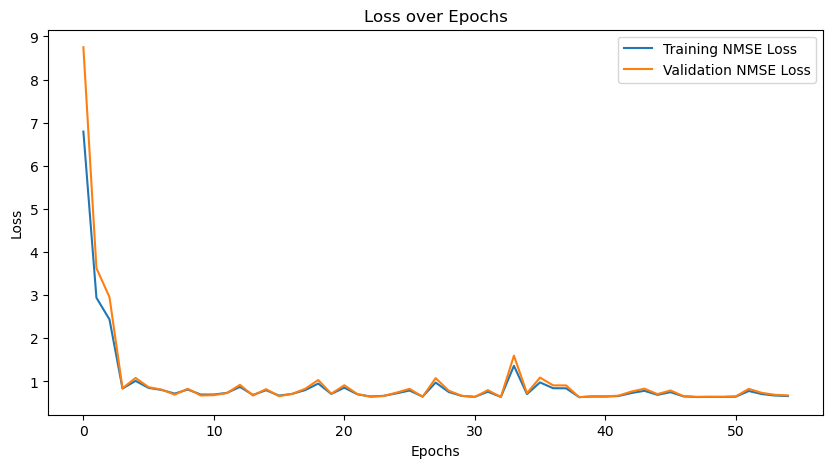

In [77]:

X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
Y = Actual_Price['Actual_Price'].diff(1)
mean = Y.mean()
Y = Y.fillna(mean).values.reshape(-1, 1)

mlp_model = MLP(num_inputs=X.shape[1], hidden_layers=[64, 32], num_outputs=1)
mlp_model.train(X, Y, val_ratio=1/3, test_ratio=1/3, num_epochs=55, learning_rate=0.01, clipvalue=1.0)

plot_losses(mlp_model)

In [74]:
predictions = mlp_model.predict(mlp_model.X_test)
predictions


array([[-0.03741399],
       [-0.01483708],
       [-0.01234791],
       ...,
       [-0.00107097],
       [-0.01426515],
       [-0.02679216]])

<AxesSubplot:>

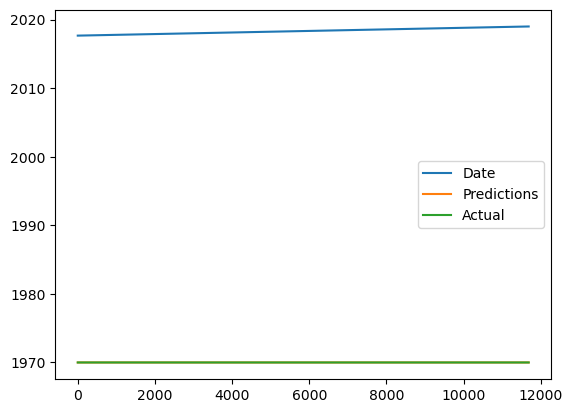

In [70]:
date_list = Actual_Price["Date"][23376:].tolist()



<AxesSubplot:>

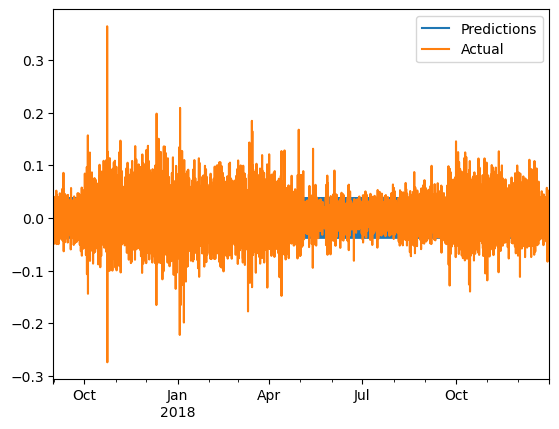

In [73]:
df = pd.DataFrame({
    "Predictions": predictions.reshape(-1).astype('float16'),
    "Actual": mlp_model.y_test.reshape(-1).astype('float16')
}, index=date_list)
df.plot()

### method 2 (differencing y(t) = log((p(t) / p(t-1)))

Epoch: 0, Training Loss (NMSE): 1.6633905557340585, Validation Loss (NMSE): 2.3983881377517067
Epoch: 1, Training Loss (NMSE): 0.8625696070533941, Validation Loss (NMSE): 0.8536401811617614
Epoch: 2, Training Loss (NMSE): 0.8470738937860153, Validation Loss (NMSE): 0.8283104417986805
Epoch: 3, Training Loss (NMSE): 0.9229581338456824, Validation Loss (NMSE): 0.9830153086798403
Epoch: 4, Training Loss (NMSE): 0.8254338619777847, Validation Loss (NMSE): 0.7998964454032066
Epoch: 5, Training Loss (NMSE): 0.8188576925559394, Validation Loss (NMSE): 0.79736348669581
Epoch: 6, Training Loss (NMSE): 0.8389971014977008, Validation Loss (NMSE): 0.8354314418081925
Epoch: 7, Training Loss (NMSE): 0.842710859681256, Validation Loss (NMSE): 0.8515754112697348
Epoch: 8, Training Loss (NMSE): 0.827011930646682, Validation Loss (NMSE): 0.8286734672947816
Epoch: 9, Training Loss (NMSE): 0.8052941250017475, Validation Loss (NMSE): 0.7926396538710928
Epoch: 10, Training Loss (NMSE): 1.036376865790095, Va

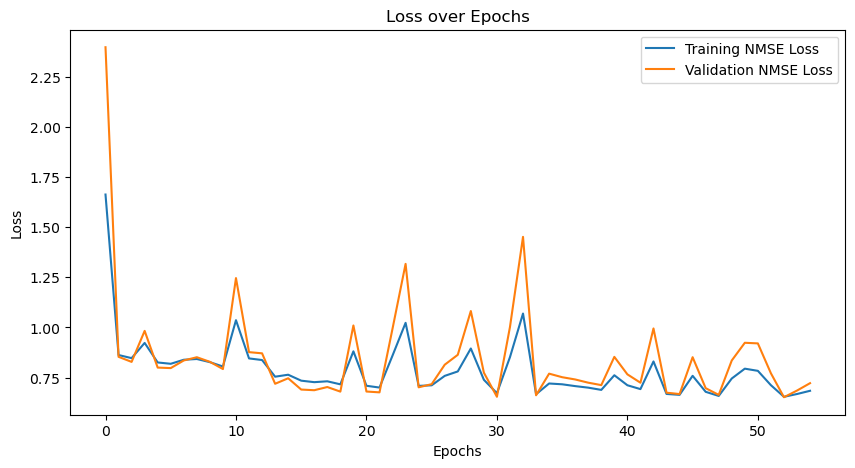

In [306]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
# differencing y(t) = log((p(t) / p(t-1)))
Y=np.log(Actual_Price['Actual_Price'] / Actual_Price['Actual_Price'].shift(1))
mean=Y.mean()
Y = Y.fillna(mean).values.reshape(-1, 1)


mlp_model = MLP(num_inputs=X.shape[1], hidden_layers=[64, 32], num_outputs=1)
mlp_model.train(X, Y, val_ratio=1/3, test_ratio=1/3, num_epochs=55, learning_rate=0.01, clipvalue=1.0)

plot_losses(mlp_model)

### method 3 differencing y(t) = (p(t) - p(t-1))/ p(t-1)

Epoch: 0, Training Loss (NMSE): 1.8997472335915713, Validation Loss (NMSE): 3.0023438826951985
Epoch: 1, Training Loss (NMSE): 0.9834027737986265, Validation Loss (NMSE): 1.0479340763761733
Epoch: 2, Training Loss (NMSE): 1.1268256468946254, Validation Loss (NMSE): 1.4241570715082736
Epoch: 3, Training Loss (NMSE): 1.1976177558210976, Validation Loss (NMSE): 1.4837675735401523
Epoch: 4, Training Loss (NMSE): 0.8350299269861192, Validation Loss (NMSE): 0.7987515535445251
Epoch: 5, Training Loss (NMSE): 1.0673400169503107, Validation Loss (NMSE): 1.2358461036337027
Epoch: 6, Training Loss (NMSE): 0.8215926431089585, Validation Loss (NMSE): 0.7849230079042829
Epoch: 7, Training Loss (NMSE): 0.8364579690302891, Validation Loss (NMSE): 0.8058902306212
Epoch: 8, Training Loss (NMSE): 1.0552298579545514, Validation Loss (NMSE): 1.2317333325648379
Epoch: 9, Training Loss (NMSE): 0.8247541414417153, Validation Loss (NMSE): 0.8189953873473348
Epoch: 10, Training Loss (NMSE): 0.7967188182763125, 

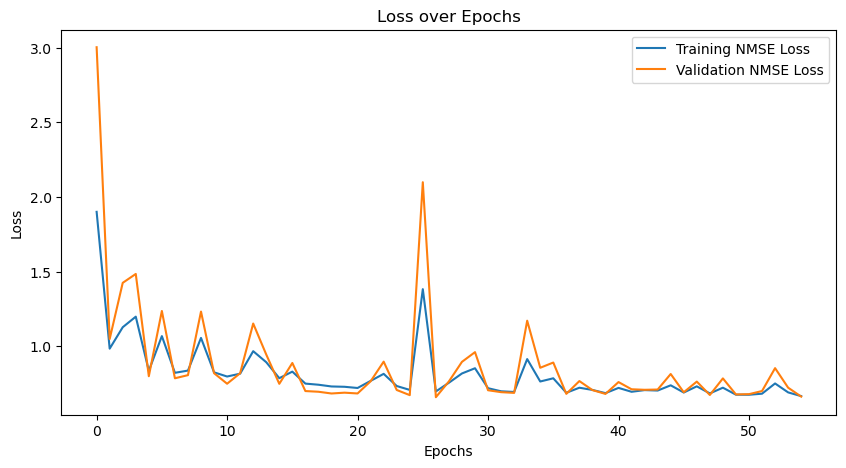

In [307]:

X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values

Y=(Actual_Price['Actual_Price'] - Actual_Price['Actual_Price'] .shift(1)) / (Actual_Price['Actual_Price'] .shift(1))
mean=Y.mean()
Y = Y.fillna(mean).values.reshape(-1, 1)


mlp_model = MLP(num_inputs=X.shape[1], hidden_layers=[64, 32], num_outputs=1)
mlp_model.train(X, Y, val_ratio=1/3, test_ratio=1/3, num_epochs=55, learning_rate=0.01, clipvalue=1.0)

plot_losses(mlp_model)

## MLP with Keras

In [207]:
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plotting the training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
# Compile the model with NMSE loss function
def nmse_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true))



In [57]:
# set random seed for reproductivity 
#from tensorflow.random import set_seed
#set_seed(40)
# Compile the model with NMSE loss function
# Separate features and target
#X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
#Y = Actual_Price['Actual_Price'].values
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/3, random_state=42)
#def nmse(y_true, y_pred):
 #   return keras.backend.mean(keras.backend.square(y_pred - y_true)) / keras.backend.mean(keras.backend.square(y_true))
# stop training after 10 epochs without improvements 
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

### method 1 (Differencing y(t) = p(t)- p(t-1))

Epoch 1/55
487/487 [==============================] - 1s 2ms/step - loss: 105.1841 - val_loss: 221.6976
Epoch 2/55
487/487 [==============================] - 1s 2ms/step - loss: 74.8041 - val_loss: 110.5035
Epoch 3/55
487/487 [==============================] - 1s 2ms/step - loss: 64.0323 - val_loss: 119.2246
Epoch 4/55
487/487 [==============================] - 1s 2ms/step - loss: 38.8948 - val_loss: 50.1636
Epoch 5/55
487/487 [==============================] - 1s 2ms/step - loss: 19.7158 - val_loss: 34.1039
Epoch 6/55
487/487 [==============================] - 1s 2ms/step - loss: 9.7776 - val_loss: 8.5943
Epoch 7/55
487/487 [==============================] - 1s 2ms/step - loss: 4.8126 - val_loss: 11.1334
Epoch 8/55
487/487 [==============================] - 1s 2ms/step - loss: 4.3631 - val_loss: 8.1055
Epoch 9/55
487/487 [==============================] - 1s 2ms/step - loss: 4.1611 - val_loss: 6.5563
Epoch 10/55
487/487 [==============================] - 1s 2ms/step - loss: 4.1109 - v

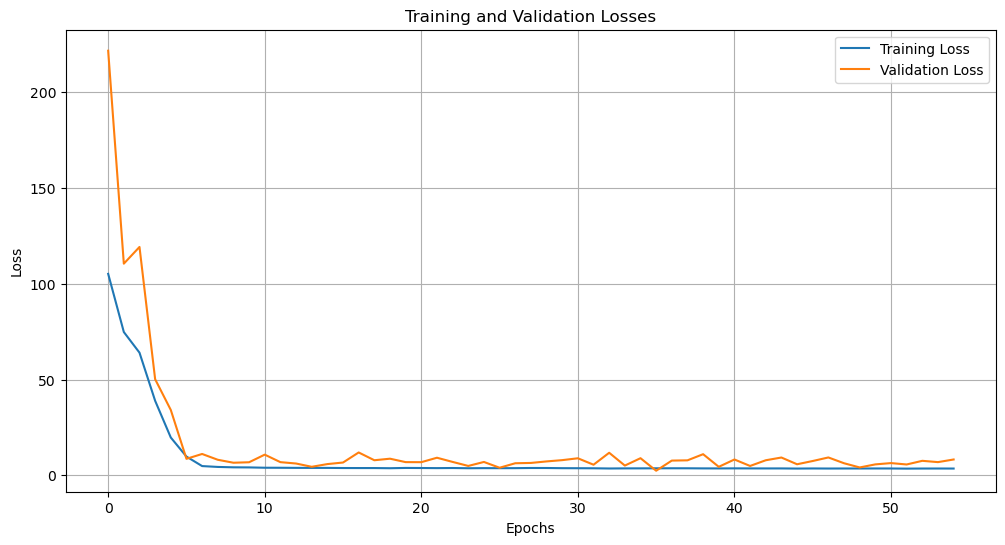

In [314]:
import keras
import numpy as np

# Separate features and target
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
keras.utils.set_random_seed(40)

# Differencing y(t) = p(t)- p(t-1)
Y = Actual_Price['Actual_Price'].diff(1)
mean = Y.mean()
Y = Y.fillna(mean).values

# Chronological split
num_samples = len(X)
test_size = int(num_samples / 3)
val_size = int((num_samples - test_size) / 3)

train_x, train_y = X[:num_samples - test_size - val_size], Y[:num_samples - test_size - val_size]
valid_x, valid_y = X[num_samples - test_size - val_size:num_samples - test_size], Y[num_samples - test_size - val_size:num_samples - test_size]
test_x, test_y = X[num_samples - test_size:], Y[num_samples - test_size:]

# Build the MLP model with the specified initializers
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros', input_shape=(train_x.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'),
    keras.layers.Dense(1, kernel_initializer='glorot_normal', bias_initializer='zeros')
])

lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr, clipvalue=1.0)
model.compile(optimizer=optimizer, loss=nmse_loss)

# Train the model
history1 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=55,batch_size=32)

# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)

# Assuming you have a function called plot_training_history to plot training history
plot_training_history(history1)


366/366 [==============================] - 1s 2ms/step


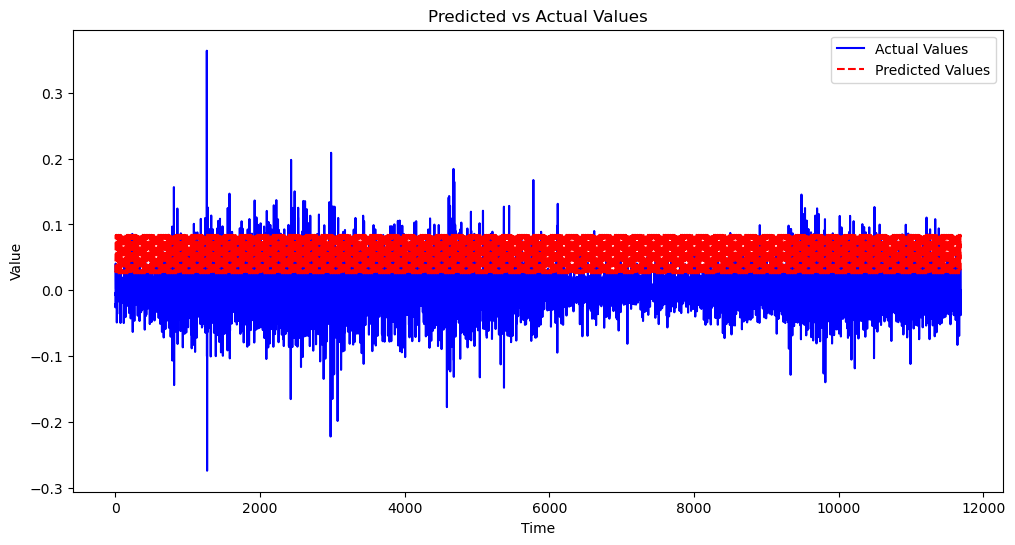

In [318]:
predictions = model.predict(test_x)
import matplotlib.pyplot as plt

def plot_predictions_vs_actual(predictions, actual):
    plt.figure(figsize=(12, 6))
    plt.plot(test_y, label='Actual Values', color='blue')
    plt.plot(predictions, label='Predicted Values', color='red', linestyle='dashed')
    plt.legend()
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

plot_predictions_vs_actual(predictions, test_y)


Epoch 1/55
487/487 [==============================] - 2s 2ms/step - loss: 126.6648 - val_loss: 136.1349
Epoch 2/55
487/487 [==============================] - 1s 2ms/step - loss: 90.9885 - val_loss: 55.3037
Epoch 3/55
487/487 [==============================] - 1s 2ms/step - loss: 78.8572 - val_loss: 77.1407
Epoch 4/55
487/487 [==============================] - 1s 2ms/step - loss: 60.3847 - val_loss: 48.1845
Epoch 5/55
487/487 [==============================] - 1s 2ms/step - loss: 45.4306 - val_loss: 33.5495
Epoch 6/55
487/487 [==============================] - 1s 2ms/step - loss: 26.9338 - val_loss: 21.9299
Epoch 7/55
487/487 [==============================] - 1s 2ms/step - loss: 17.0003 - val_loss: 12.6116
Epoch 8/55
487/487 [==============================] - 1s 2ms/step - loss: 12.4182 - val_loss: 10.5165
Epoch 9/55
487/487 [==============================] - 1s 2ms/step - loss: 7.3649 - val_loss: 5.0694
Epoch 10/55
487/487 [==============================] - 1s 2ms/step - loss: 5.8873 

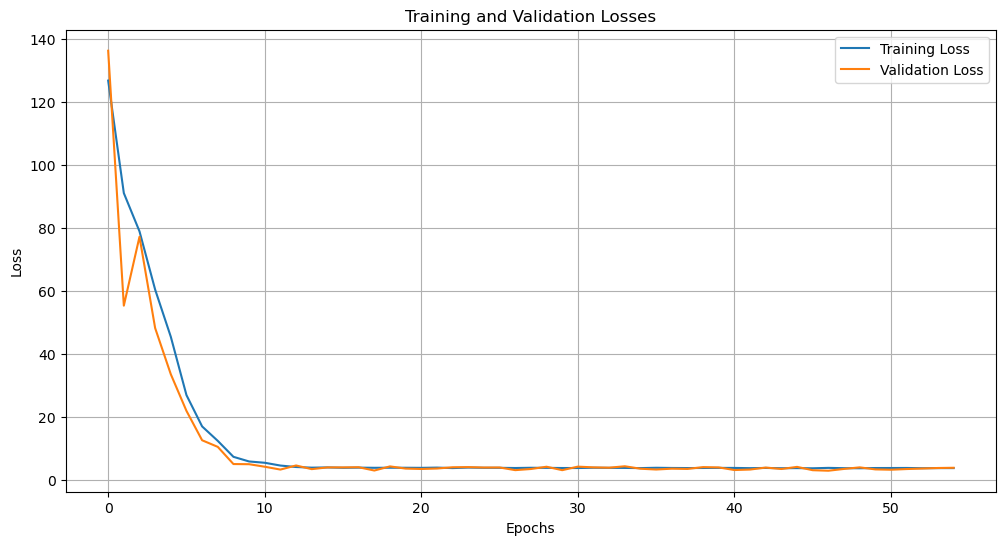

In [221]:

# Separate features and target
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
keras.utils.set_random_seed(40)

# Differencing y(t) = p(t)- p(t-1)
Y = Actual_Price['Actual_Price'].diff(1)
mean = Y.mean()
Y = Y.fillna(mean).values

train_x, test_x, train_y, test_y = train_test_split(X,  Y, test_size=1/3, random_state=40 ) 
# stratified train validation split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=1/3, random_state=40 )
# Build the MLP model with the specified initializers
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid',kernel_initializer='glorot_normal', bias_initializer='zeros',input_shape=(train_x.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'),
    keras.layers.Dense(1, kernel_initializer='glorot_normal', bias_initializer='zeros')  
    # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0)
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history1 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=55)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)

# Assuming you have a function called plot_training_history to plot training history
plot_training_history(history1)

### method 2 (differencing y(t) = log((p(t) / p(t-1)))

Epoch 1/55
487/487 [==============================] - 5s 6ms/step - loss: 14.7447 - val_loss: 18.0044
Epoch 2/55
487/487 [==============================] - 3s 5ms/step - loss: 2.6409 - val_loss: 0.8646
Epoch 3/55
487/487 [==============================] - 2s 5ms/step - loss: 1.1559 - val_loss: 1.8128
Epoch 4/55
487/487 [==============================] - 2s 5ms/step - loss: 1.0837 - val_loss: 0.8746
Epoch 5/55
487/487 [==============================] - 3s 6ms/step - loss: 1.0348 - val_loss: 0.9141
Epoch 6/55
487/487 [==============================] - 3s 5ms/step - loss: 0.9806 - val_loss: 0.9495
Epoch 7/55
487/487 [==============================] - 2s 5ms/step - loss: 1.0494 - val_loss: 0.7839
Epoch 8/55
487/487 [==============================] - 2s 3ms/step - loss: 1.0038 - val_loss: 1.2517
Epoch 9/55
487/487 [==============================] - 2s 3ms/step - loss: 0.9648 - val_loss: 0.9504
Epoch 10/55
487/487 [==============================] - 2s 4ms/step - loss: 0.9573 - val_loss: 1.54

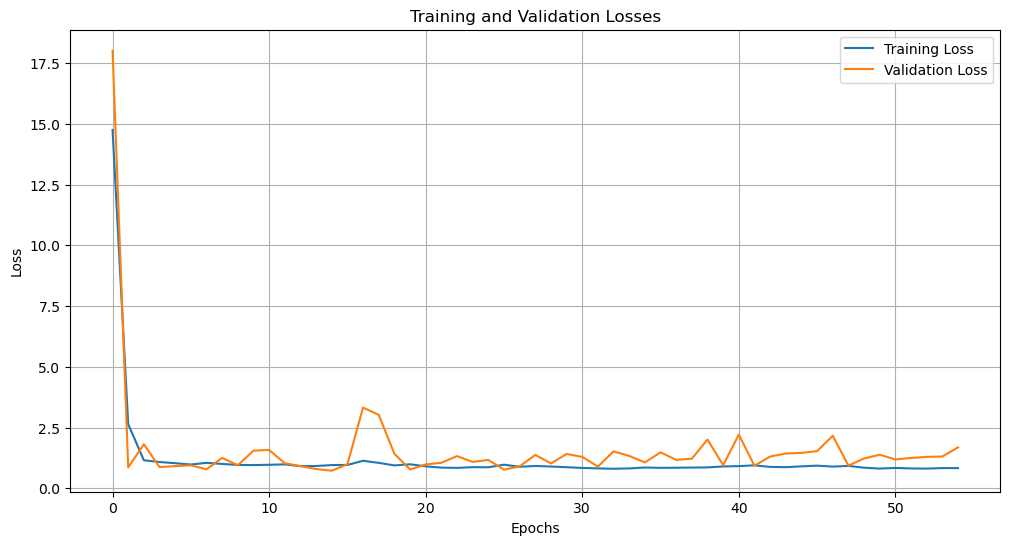

In [304]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
# differencing y(t) = log((p(t) / p(t-1)))
Y=np.log(Actual_Price['Actual_Price'] / Actual_Price['Actual_Price'].shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values
# Chronological split
num_samples = len(X)
test_size = int(num_samples / 3)
val_size = int((num_samples - test_size) / 3)

train_x, train_y = X[:num_samples - test_size - val_size], Y[:num_samples - test_size - val_size]
valid_x, valid_y = X[num_samples - test_size - val_size:num_samples - test_size], Y[num_samples - test_size - val_size:num_samples - test_size]
test_x, test_y = X[num_samples - test_size:], Y[num_samples - test_size:]

model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid',kernel_initializer='glorot_normal', bias_initializer='zeros',input_shape=(train_x.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'),
    keras.layers.Dense(1, kernel_initializer='glorot_normal', bias_initializer='zeros')  
    # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0)
model.compile(optimizer=optimizer, loss=nmse_loss)
# Train the model
history2 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=55,batch_size=32)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:", loss)

# Assuming you have a function called plot_training_history to plot training history
plot_training_history(history2)

Epoch 1/15
487/487 [==============================] - 2s 3ms/step - loss: 18.0397 - val_loss: 12.9489
Epoch 2/15
487/487 [==============================] - 1s 3ms/step - loss: 7.7097 - val_loss: 4.1176
Epoch 3/15
487/487 [==============================] - 1s 3ms/step - loss: 1.6997 - val_loss: 1.5476
Epoch 4/15
487/487 [==============================] - 1s 3ms/step - loss: 1.1562 - val_loss: 1.3228
Epoch 5/15
487/487 [==============================] - 2s 5ms/step - loss: 1.0965 - val_loss: 1.0501
Epoch 6/15
487/487 [==============================] - 2s 4ms/step - loss: 1.0581 - val_loss: 1.2998
Epoch 7/15
487/487 [==============================] - 2s 3ms/step - loss: 1.0245 - val_loss: 1.0004
Epoch 8/15
487/487 [==============================] - 2s 3ms/step - loss: 0.9587 - val_loss: 0.8460
Epoch 9/15
487/487 [==============================] - 2s 3ms/step - loss: 0.9317 - val_loss: 0.8799
Epoch 10/15
487/487 [==============================] - 1s 3ms/step - loss: 0.9380 - val_loss: 0.88

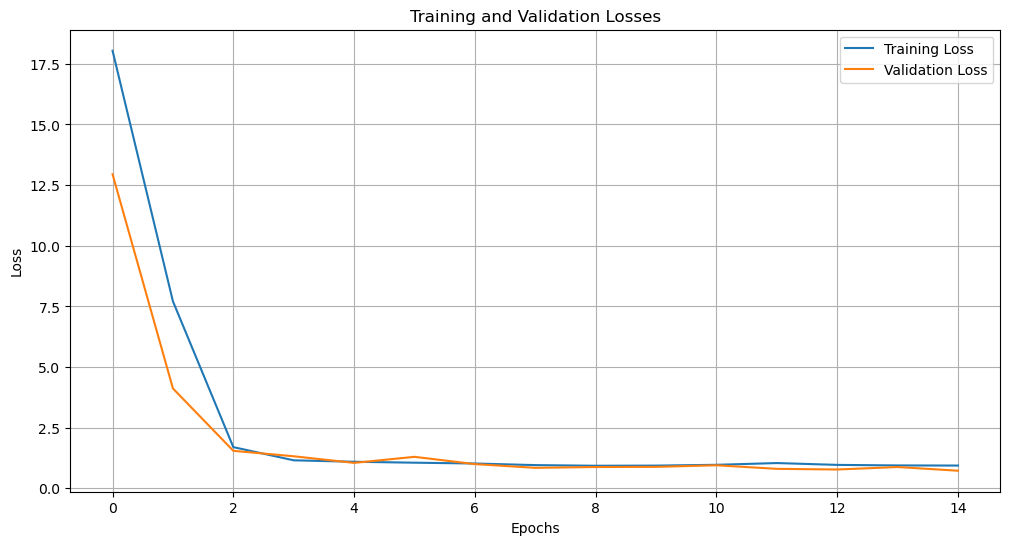

In [284]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
# differencing y(t) = log((p(t) / p(t-1)))
Y=np.log(Actual_Price['Actual_Price'] / Actual_Price['Actual_Price'].shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values

train_x, test_x, train_y, test_y = train_test_split(X,  Y, test_size=1/3) 
# stratified train validation split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=1/3)
# Build the MLP model with the specified initializers
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid',kernel_initializer='glorot_normal', bias_initializer='zeros',input_shape=(train_x.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'),
    keras.layers.Dense(1, kernel_initializer='glorot_normal', bias_initializer='zeros')  
    # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0)
model.compile(optimizer=optimizer, loss=nmse_loss)
# Train the model
history2 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=15,batch_size=32)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:", loss)

# Assuming you have a function called plot_training_history to plot training history
plot_training_history(history2)

### method 3 differencing y(t) = (p(t) - p(t-1))/ p(t-1)

Epoch 1/55
487/487 [==============================] - 5s 6ms/step - loss: 14.1270 - val_loss: 13.3707
Epoch 2/55
487/487 [==============================] - 3s 6ms/step - loss: 2.2080 - val_loss: 1.0189
Epoch 3/55
487/487 [==============================] - 2s 4ms/step - loss: 1.0375 - val_loss: 2.0750
Epoch 4/55
487/487 [==============================] - 2s 4ms/step - loss: 1.0087 - val_loss: 1.5807
Epoch 5/55
487/487 [==============================] - 2s 4ms/step - loss: 1.0455 - val_loss: 1.4580
Epoch 6/55
487/487 [==============================] - 2s 4ms/step - loss: 1.0925 - val_loss: 0.8679
Epoch 7/55
487/487 [==============================] - 2s 5ms/step - loss: 1.0143 - val_loss: 1.3852
Epoch 8/55
487/487 [==============================] - 2s 5ms/step - loss: 0.9892 - val_loss: 0.9916
Epoch 9/55
487/487 [==============================] - 3s 6ms/step - loss: 1.0107 - val_loss: 0.8942
Epoch 10/55
487/487 [==============================] - 2s 5ms/step - loss: 0.9915 - val_loss: 2.00

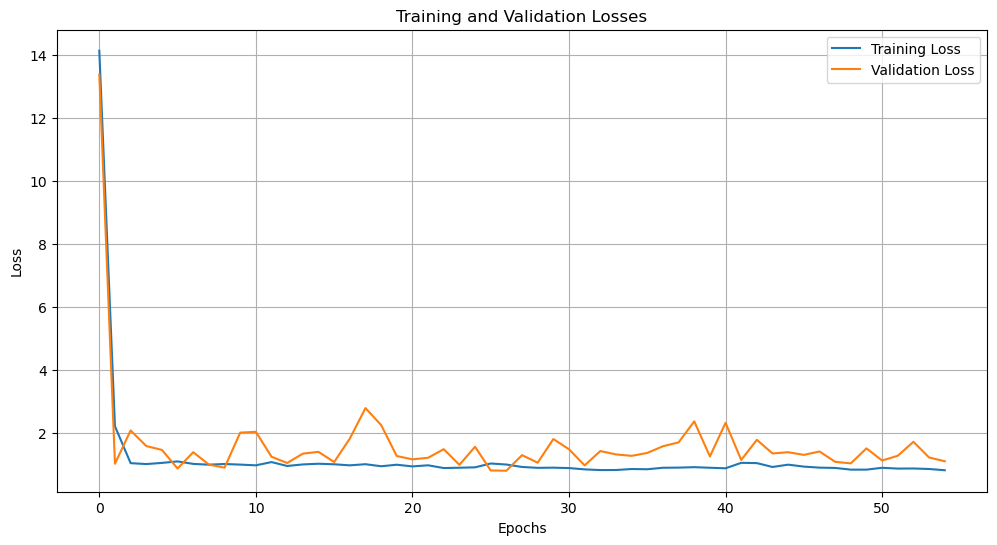

In [310]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values

Y=(Actual_Price['Actual_Price'] - Actual_Price['Actual_Price'] .shift(1)) / (Actual_Price['Actual_Price'] .shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values
# Chronological split
num_samples = len(X)
test_size = int(num_samples / 3)
val_size = int((num_samples - test_size) / 3)

train_x, train_y = X[:num_samples - test_size - val_size], Y[:num_samples - test_size - val_size]
valid_x, valid_y = X[num_samples - test_size - val_size:num_samples - test_size], Y[num_samples - test_size - val_size:num_samples - test_size]
test_x, test_y = X[num_samples - test_size:], Y[num_samples - test_size:]
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid',kernel_initializer='glorot_normal', bias_initializer='zeros',input_shape=(train_x.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'),
    keras.layers.Dense(1, kernel_initializer='glorot_normal', bias_initializer='zeros')  
    # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0)
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history3 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=55,batch_size=32)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:", loss)

# Assuming you have a function called plot_training_history to plot training history
plot_training_history(history3)

Epoch 1/25
487/487 [==============================] - 2s 3ms/step - loss: 18.6196 - val_loss: 12.9141
Epoch 2/25
487/487 [==============================] - 1s 2ms/step - loss: 5.6738 - val_loss: 1.2127
Epoch 3/25
487/487 [==============================] - 1s 2ms/step - loss: 1.6886 - val_loss: 1.9584
Epoch 4/25
487/487 [==============================] - 1s 2ms/step - loss: 1.4585 - val_loss: 1.2344
Epoch 5/25
487/487 [==============================] - 1s 2ms/step - loss: 1.3580 - val_loss: 1.3629
Epoch 6/25
487/487 [==============================] - 1s 2ms/step - loss: 1.3814 - val_loss: 1.1767
Epoch 7/25
487/487 [==============================] - 1s 2ms/step - loss: 1.2438 - val_loss: 1.3499
Epoch 8/25
487/487 [==============================] - 1s 2ms/step - loss: 1.2807 - val_loss: 1.0101
Epoch 9/25
487/487 [==============================] - 1s 2ms/step - loss: 1.1777 - val_loss: 1.0804
Epoch 10/25
487/487 [==============================] - 1s 2ms/step - loss: 1.2154 - val_loss: 1.04

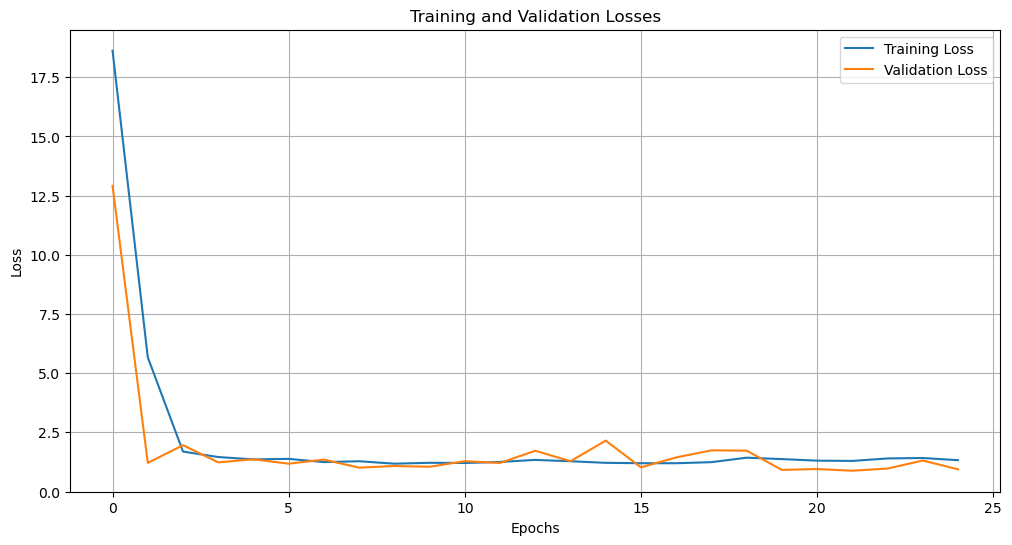

In [128]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values

Y=(Actual_Price['Actual_Price'] - Actual_Price['Actual_Price'] .shift(1)) / (Actual_Price['Actual_Price'] .shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values

train_x, test_x, train_y, test_y = train_test_split(X,  Y, test_size=1/3) 
# stratified train validation split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=1/3)
# Build the MLP model with the specified initializers
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid',kernel_initializer='glorot_normal', bias_initializer='zeros',input_shape=(train_x.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'),
    keras.layers.Dense(1, kernel_initializer='glorot_normal', bias_initializer='zeros')  
    # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0)
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history3 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=55,batch_size=32)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:", loss)

# Assuming you have a function called plot_training_history to plot training history
plot_training_history(history3)

## LSTM

### method 1 (Differencing y(t) = p(t)- p(t-1))

Epoch 1/55
487/487 [==============================] - 6s 6ms/step - loss: 24.6940 - val_loss: 39.5161
Epoch 2/55
487/487 [==============================] - 2s 4ms/step - loss: 17.2890 - val_loss: 32.0691
Epoch 3/55
487/487 [==============================] - 2s 5ms/step - loss: 12.8793 - val_loss: 20.8703
Epoch 4/55
487/487 [==============================] - 2s 5ms/step - loss: 10.2764 - val_loss: 18.4504
Epoch 5/55
487/487 [==============================] - 2s 4ms/step - loss: 8.2016 - val_loss: 15.6925
Epoch 6/55
487/487 [==============================] - 2s 5ms/step - loss: 6.3841 - val_loss: 9.8788
Epoch 7/55
487/487 [==============================] - 2s 5ms/step - loss: 5.2500 - val_loss: 11.2257
Epoch 8/55
487/487 [==============================] - 2s 4ms/step - loss: 4.4122 - val_loss: 10.0966
Epoch 9/55
487/487 [==============================] - 3s 6ms/step - loss: 3.9498 - val_loss: 8.0921
Epoch 10/55
487/487 [==============================] - 3s 6ms/step - loss: 3.4885 - val_l

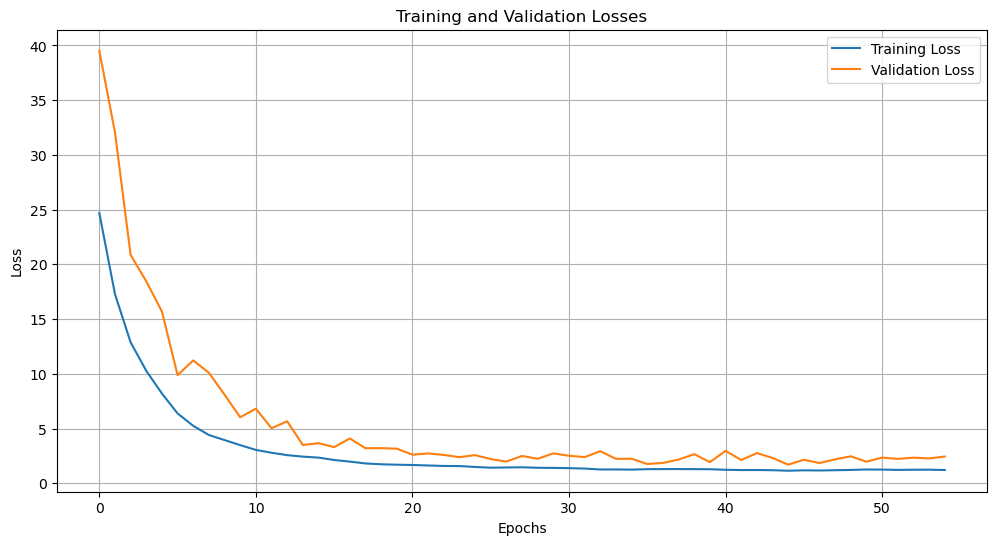

In [311]:
# Separate features and target
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
keras.utils.set_random_seed(40)

# Differencing y(t) = p(t)- p(t-1)
Y = Actual_Price['Actual_Price'].diff(1)
mean = Y.mean()
Y = Y.fillna(mean).values

# Chronological split
num_samples = len(X)
test_size = int(num_samples / 3)
val_size = int((num_samples - test_size) / 3)

train_x, train_y = X[:num_samples - test_size - val_size], Y[:num_samples - test_size - val_size]
valid_x, valid_y = X[num_samples - test_size - val_size:num_samples - test_size], Y[num_samples - test_size - val_size:num_samples - test_size]
test_x, test_y = X[num_samples - test_size:], Y[num_samples - test_size:]

# modify the data dimension for lstm 
train_x = train_x.reshape(-1, 1, 3)
test_x  = test_x.reshape(-1, 1, 3)
train_y = train_y.reshape(-1, 1, 1)
test_y = test_y.reshape(-1, 1, 1)
valid_x = valid_x.reshape(-1, 1, 3)
valid_y = valid_y.reshape(-1, 1, 1)
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=( 1, 3), return_sequences=True),
    keras.layers.Dense(1)  # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0 )
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history4 = model.fit(train_x, train_y,validation_data=(valid_x, valid_y), epochs=55)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:",loss)
plot_training_history(history4)

Epoch 1/55
487/487 [==============================] - 7s 7ms/step - loss: 48.9776 - val_loss: 31.9553
Epoch 2/55
487/487 [==============================] - 2s 4ms/step - loss: 28.5855 - val_loss: 21.1211
Epoch 3/55
487/487 [==============================] - 2s 4ms/step - loss: 20.3943 - val_loss: 17.4614
Epoch 4/55
487/487 [==============================] - 2s 4ms/step - loss: 15.5204 - val_loss: 13.9359
Epoch 5/55
487/487 [==============================] - 2s 4ms/step - loss: 12.5775 - val_loss: 10.3141
Epoch 6/55
487/487 [==============================] - 2s 4ms/step - loss: 10.0979 - val_loss: 9.0359
Epoch 7/55
487/487 [==============================] - 2s 5ms/step - loss: 8.6135 - val_loss: 7.9667
Epoch 8/55
487/487 [==============================] - 2s 5ms/step - loss: 7.7606 - val_loss: 6.7733
Epoch 9/55
487/487 [==============================] - 2s 5ms/step - loss: 7.0654 - val_loss: 7.4369
Epoch 10/55
487/487 [==============================] - 2s 4ms/step - loss: 6.3360 - val_l

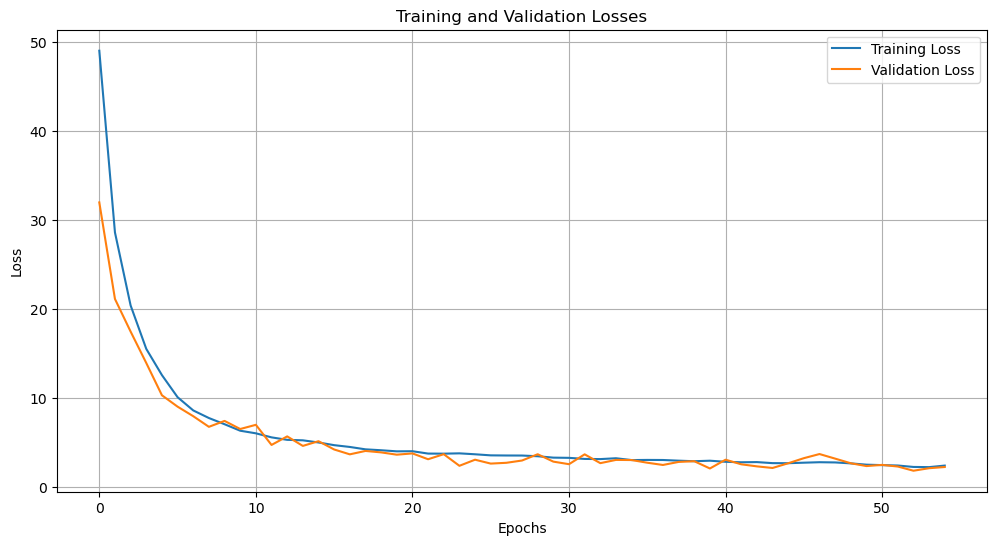

In [130]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values

# Differencing y(t) = p(t)- p(t-1)
Y = Actual_Price['Actual_Price'].diff(1)
mean = Y.mean()
Y = Y.fillna(mean).values
# Split the data into train and test sets  ,random_state=42
train_x, test_x, train_y, test_y = train_test_split(X,  Y, test_size=1/3,random_state=42) 
# stratified train validation split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=1/3,random_state=42)
# Build the LSTM model with nmse as loss function, SGD as optimizer and two hidden layers

# modify the data dimension for lstm 
train_x = train_x.reshape(-1, 1, 3)
test_x  = test_x.reshape(-1, 1, 3)
train_y = train_y.reshape(-1, 1, 1)
test_y = test_y.reshape(-1, 1, 1)
valid_x = valid_x.reshape(-1, 1, 3)
valid_y = valid_y.reshape(-1, 1, 1)
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=( 1, 3), return_sequences=True),
    keras.layers.Dense(1)  # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0 )
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history4 = model.fit(train_x, train_y,validation_data=(valid_x, valid_y), epochs=55)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:",loss)
plot_training_history(history4)

### method 2 (differencing y(t) = log((p(t) / p(t-1)))

Epoch 1/55
487/487 [==============================] - 5s 6ms/step - loss: 4.2626 - val_loss: 6.5685
Epoch 2/55
487/487 [==============================] - 2s 4ms/step - loss: 2.3111 - val_loss: 3.9562
Epoch 3/55
487/487 [==============================] - 2s 4ms/step - loss: 1.7379 - val_loss: 2.9201
Epoch 4/55
487/487 [==============================] - 2s 4ms/step - loss: 1.2545 - val_loss: 1.2373
Epoch 5/55
487/487 [==============================] - 3s 5ms/step - loss: 0.9324 - val_loss: 1.7850
Epoch 6/55
487/487 [==============================] - 3s 5ms/step - loss: 0.8354 - val_loss: 0.8732
Epoch 7/55
487/487 [==============================] - 2s 4ms/step - loss: 0.8109 - val_loss: 1.6595
Epoch 8/55
487/487 [==============================] - 2s 4ms/step - loss: 0.7810 - val_loss: 1.4043
Epoch 9/55
487/487 [==============================] - 2s 4ms/step - loss: 0.7908 - val_loss: 2.0138
Epoch 10/55
487/487 [==============================] - 2s 4ms/step - loss: 0.8335 - val_loss: 1.9908

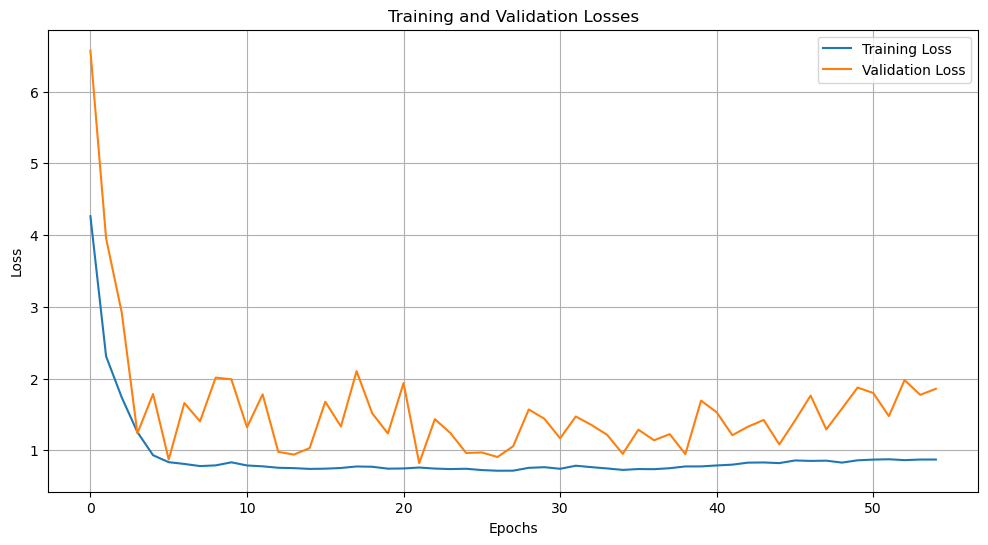

In [312]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
# differencing y(t) = log((p(t) / p(t-1)))
Y=np.log(Actual_Price['Actual_Price'] / Actual_Price['Actual_Price'].shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values
# Chronological split
num_samples = len(X)
test_size = int(num_samples / 3)
val_size = int((num_samples - test_size) / 3)

train_x, train_y = X[:num_samples - test_size - val_size], Y[:num_samples - test_size - val_size]
valid_x, valid_y = X[num_samples - test_size - val_size:num_samples - test_size], Y[num_samples - test_size - val_size:num_samples - test_size]
test_x, test_y = X[num_samples - test_size:], Y[num_samples - test_size:]

# modify the data dimension for lstm 
train_x = train_x.reshape(-1, 1, 3)
test_x  = test_x.reshape(-1, 1, 3)
train_y = train_y.reshape(-1, 1, 1)
test_y = test_y.reshape(-1, 1, 1)
valid_x = valid_x.reshape(-1, 1, 3)
valid_y = valid_y.reshape(-1, 1, 1)
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=( 1, 3), return_sequences=True),
    keras.layers.Dense(1)  # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0 )
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history5 = model.fit(train_x, train_y,validation_data=(valid_x, valid_y), epochs=55)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:",loss)
plot_training_history(history5)

Epoch 1/55
487/487 [==============================] - 7s 7ms/step - loss: 4.8834 - val_loss: 3.5933
Epoch 2/55
487/487 [==============================] - 3s 6ms/step - loss: 2.4973 - val_loss: 1.3777
Epoch 3/55
487/487 [==============================] - 2s 5ms/step - loss: 1.6501 - val_loss: 1.0271
Epoch 4/55
487/487 [==============================] - 2s 4ms/step - loss: 1.2634 - val_loss: 0.9479
Epoch 5/55
487/487 [==============================] - 2s 5ms/step - loss: 1.0804 - val_loss: 0.9314
Epoch 6/55
487/487 [==============================] - 2s 5ms/step - loss: 0.9846 - val_loss: 0.8868
Epoch 7/55
487/487 [==============================] - 3s 6ms/step - loss: 0.9347 - val_loss: 0.8387
Epoch 8/55
487/487 [==============================] - 3s 5ms/step - loss: 0.9113 - val_loss: 0.7190
Epoch 9/55
487/487 [==============================] - 3s 5ms/step - loss: 0.8413 - val_loss: 0.8836
Epoch 10/55
487/487 [==============================] - 2s 5ms/step - loss: 0.7863 - val_loss: 1.0402

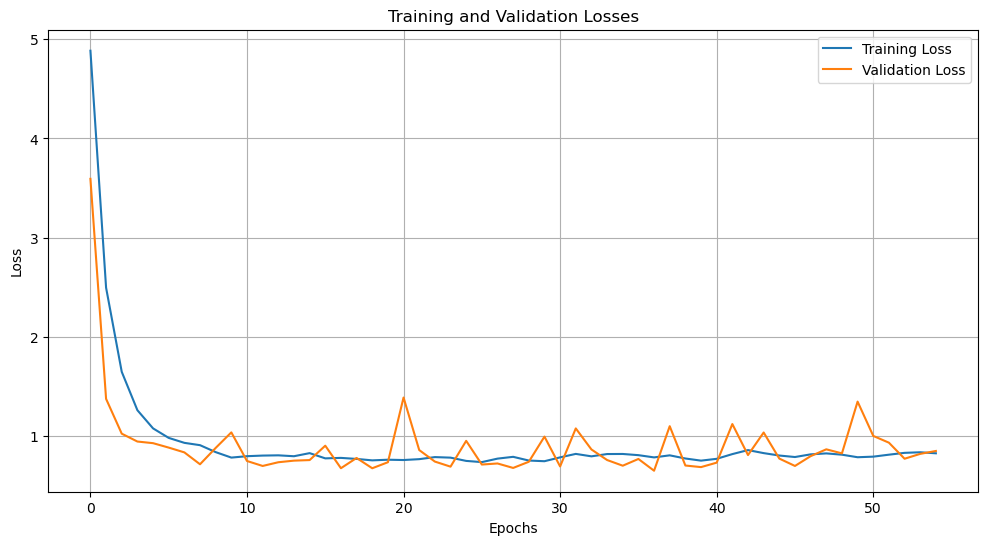

In [131]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values
# differencing y(t) = log((p(t) / p(t-1)))
Y=np.log(Actual_Price['Actual_Price'] / Actual_Price['Actual_Price'].shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values
train_x, test_x, train_y, test_y = train_test_split(X,  Y, test_size=1/3,random_state=42) 
# stratified train validation split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=1/3,random_state=42)
# Build the LSTM model with nmse as loss function, SGD as optimizer and two hidden layers

# modify the data dimension for lstm 
train_x = train_x.reshape(-1, 1, 3)
test_x  = test_x.reshape(-1, 1, 3)
train_y = train_y.reshape(-1, 1, 1)
test_y = test_y.reshape(-1, 1, 1)
valid_x = valid_x.reshape(-1, 1, 3)
valid_y = valid_y.reshape(-1, 1, 1)
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=( 1, 3), return_sequences=True),
    keras.layers.Dense(1)  # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0 )
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history5 = model.fit(train_x, train_y,validation_data=(valid_x, valid_y), epochs=55)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:",loss)
plot_training_history(history5)

### method 3 differencing y(t) = (p(t) - p(t-1))/ p(t-1)

Epoch 1/55
487/487 [==============================] - 6s 7ms/step - loss: 3.9317 - val_loss: 6.5225
Epoch 2/55
487/487 [==============================] - 2s 4ms/step - loss: 2.3842 - val_loss: 3.6390
Epoch 3/55
487/487 [==============================] - 2s 4ms/step - loss: 1.6705 - val_loss: 3.1336
Epoch 4/55
487/487 [==============================] - 2s 4ms/step - loss: 1.3686 - val_loss: 1.3647
Epoch 5/55
487/487 [==============================] - 2s 5ms/step - loss: 1.1719 - val_loss: 2.3295
Epoch 6/55
487/487 [==============================] - 3s 5ms/step - loss: 1.0371 - val_loss: 1.1298
Epoch 7/55
487/487 [==============================] - 2s 5ms/step - loss: 0.9933 - val_loss: 1.8937
Epoch 8/55
487/487 [==============================] - 2s 4ms/step - loss: 0.9012 - val_loss: 1.3947
Epoch 9/55
487/487 [==============================] - 2s 4ms/step - loss: 0.9011 - val_loss: 1.2988
Epoch 10/55
487/487 [==============================] - 2s 5ms/step - loss: 0.8909 - val_loss: 1.2105

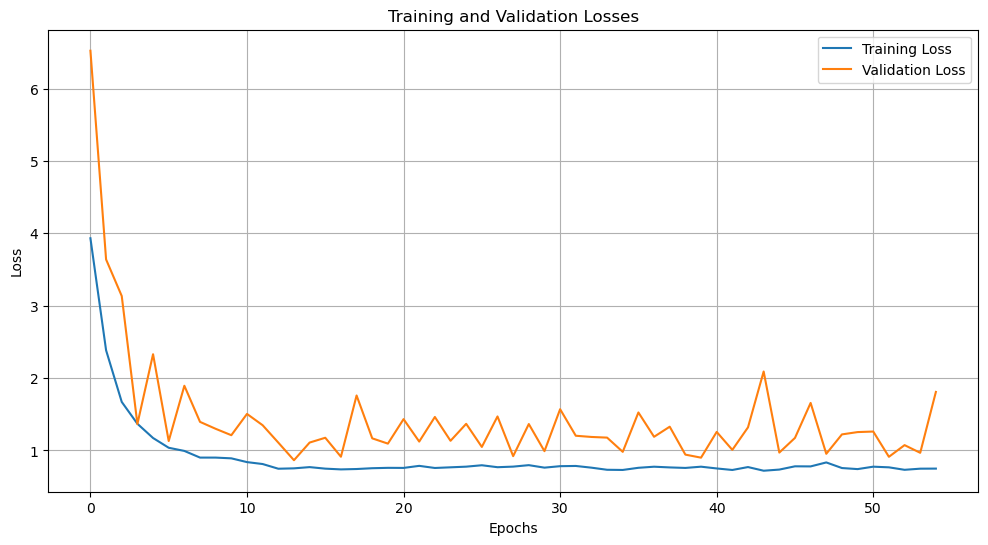

In [313]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values

Y=(Actual_Price['Actual_Price'] - Actual_Price['Actual_Price'] .shift(1)) / (Actual_Price['Actual_Price'] .shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values
# Chronological split
num_samples = len(X)
test_size = int(num_samples / 3)
val_size = int((num_samples - test_size) / 3)

train_x, train_y = X[:num_samples - test_size - val_size], Y[:num_samples - test_size - val_size]
valid_x, valid_y = X[num_samples - test_size - val_size:num_samples - test_size], Y[num_samples - test_size - val_size:num_samples - test_size]
test_x, test_y = X[num_samples - test_size:], Y[num_samples - test_size:]
# modify the data dimension for lstm 
train_x = train_x.reshape(-1, 1, 3)
test_x  = test_x.reshape(-1, 1, 3)
train_y = train_y.reshape(-1, 1, 1)
test_y = test_y.reshape(-1, 1, 1)
valid_x = valid_x.reshape(-1, 1, 3)
valid_y = valid_y.reshape(-1, 1, 1)
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=( 1, 3), return_sequences=True),
    keras.layers.Dense(1)  # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0 )
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history6 = model.fit(train_x, train_y,validation_data=(valid_x, valid_y), epochs=55)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:",loss)
plot_training_history(history6)


Epoch 1/55
487/487 [==============================] - 6s 7ms/step - loss: 5.7044 - val_loss: 2.9856
Epoch 2/55
487/487 [==============================] - 2s 5ms/step - loss: 3.0128 - val_loss: 2.3224
Epoch 3/55
487/487 [==============================] - 2s 5ms/step - loss: 2.1330 - val_loss: 0.9883
Epoch 4/55
487/487 [==============================] - 3s 5ms/step - loss: 1.5706 - val_loss: 1.1195
Epoch 5/55
487/487 [==============================] - 2s 5ms/step - loss: 1.4300 - val_loss: 1.2221
Epoch 6/55
487/487 [==============================] - 2s 5ms/step - loss: 1.2192 - val_loss: 1.1995
Epoch 7/55
487/487 [==============================] - 2s 5ms/step - loss: 1.1337 - val_loss: 0.7863
Epoch 8/55
487/487 [==============================] - 3s 6ms/step - loss: 1.1042 - val_loss: 0.7566
Epoch 9/55
487/487 [==============================] - 3s 6ms/step - loss: 1.1421 - val_loss: 1.0713
Epoch 10/55
487/487 [==============================] - 2s 5ms/step - loss: 1.1043 - val_loss: 1.0892

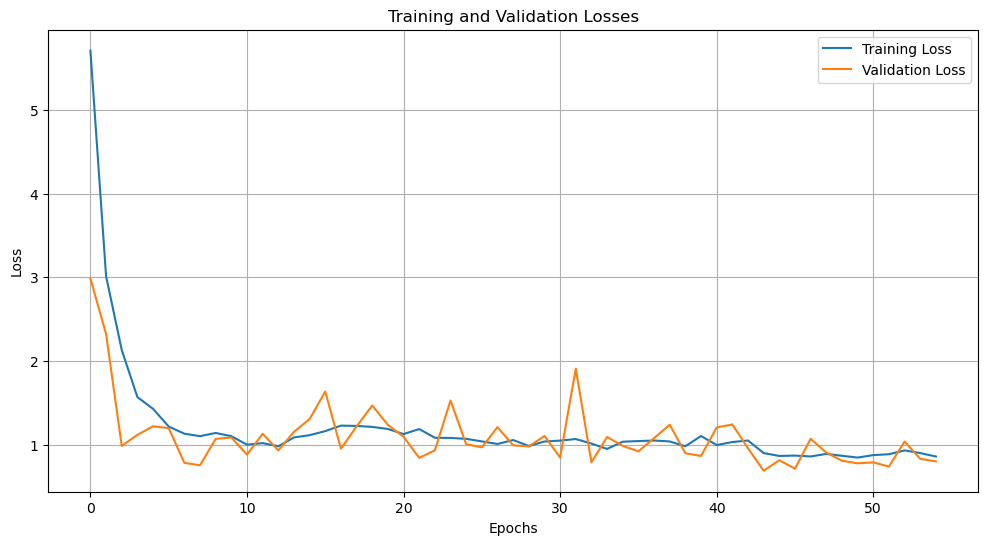

In [132]:
X = Actual_Price.drop(['Date', 'Actual_Price'], axis=1).values

Y=(Actual_Price['Actual_Price'] - Actual_Price['Actual_Price'] .shift(1)) / (Actual_Price['Actual_Price'] .shift(1))
mean=Y.mean()
Y=Y.fillna(mean).values

train_x, test_x, train_y, test_y = train_test_split(X,  Y, test_size=1/3,random_state=42) 
# stratified train validation split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=1/3,random_state=42)
# Build the LSTM model with nmse as loss function, SGD as optimizer and two hidden layers

# modify the data dimension for lstm 
train_x = train_x.reshape(-1, 1, 3)
test_x  = test_x.reshape(-1, 1, 3)
train_y = train_y.reshape(-1, 1, 1)
test_y = test_y.reshape(-1, 1, 1)
valid_x = valid_x.reshape(-1, 1, 3)
valid_y = valid_y.reshape(-1, 1, 1)
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=( 1, 3), return_sequences=True),
    keras.layers.Dense(1)  # Output layer with no activation function for regression tasks
])
lr = 0.01
optimizer = keras.optimizers.SGD(learning_rate=lr,  clipvalue=1.0 )
model.compile(optimizer=optimizer, loss=nmse_loss)# Train the model
history6 = model.fit(train_x, train_y,validation_data=(valid_x, valid_y), epochs=55)
# Evaluate the model on the test set
loss = model.evaluate(test_x, test_y)
print("Mean Squared Error on test set:",loss)
plot_training_history(history6)


In [ ]:
# Importing necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming 'Actual_Price' is a list or array of your time series data
# Convert 'Actual_Price' to a numpy array and reshape it to a 2D array 
# so it can be input into the MinMaxScaler
data = np.array(Actual_Price).reshape((len(Actual_Price), 1))

# Create a MinMaxScaler instance. The feature_range=(0, 1) ensures 
# the scaled values are between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'data' using the scaler. This method first determines 
# the minimum and maximum values in 'data' (used for scaling), 
# and then scales the data based on those values.
scaled_data = scaler.fit_transform(data)

# Convert the 2D 'scaled_data' to a 1D array for ease of use
scaled_data_1D = scaled_data.ravel()

# Convert the 1D scaled data into a pandas DataFrame
Scaled_Actual_Price = pd.DataFrame(scaled_data_1D, columns=['scaled_Actual_Price'])

# Assuming 'df' is your original DataFrame, copy the 'time' column 
# from it to the new DataFrame 'df_scaled'
Scaled_Actual_Price['time'] = df['time']

# Convert the 'time' column to a datetime object. This helps in 
# ensuring the time data is in a consistent format and can be 
# used as an index for time series operations
Scaled_Actual_Price['time'] = pd.to_datetime(Scaled_Actual_Price['time'], utc=False, infer_datetime_format=True)

# Set the 'time' column as the index for the DataFrame. This 
# makes it easier to perform time series operations on the DataFrame
Scaled_Actual_Price = Scaled_Actual_Price.set_index('time')

# Print the minimum and maximum values of the original 'data'. 
# Useful for understanding the range before scaling
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

# Print the scaled DataFrame
print(Scaled_Actual_Price)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(40)  # Set the random seed for reproducibility

class MLP:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.layers = [num_inputs] + hidden_layers + [num_outputs]
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layers) - 1):
            # Using Xavier/Glorot initialization for sigmoid activation
            weight = np.random.normal(0, np.sqrt(1 / self.layers[i]), 
                                      (self.layers[i], self.layers[i + 1]))
            bias = np.zeros(self.layers[i + 1])
            self.weights.append(weight)
            self.biases.append(bias)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_pass(self, inputs):
        self.activation_outputs = [inputs]
        for i in range(len(self.layers) - 2):
            inputs = self.sigmoid(np.dot(inputs, self.weights[i]) + self.biases[i])
            self.activation_outputs.append(inputs)
        outputs = np.dot(inputs, self.weights[-1]) + self.biases[-1]
        self.activation_outputs.append(outputs)
        return outputs

    def mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        return np.mean((actual - predicted)**2)

    def normalized_mean_squared_error_loss(self, actual):
        predicted = self.activation_outputs[-1]
        variance = np.var(actual)
        mse = self.mean_squared_error_loss(actual)
        return mse / variance

    def validate(self, inputs, labels):
        outputs = self.forward_pass(inputs)
        loss = self.normalized_mean_squared_error_loss(labels)
        return loss

    def backpropagation(self, actual, learning_rate):
        output_error = actual - self.activation_outputs[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.sigmoid_derivative(self.activation_outputs[i])
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            weight_gradient = np.dot(self.activation_outputs[i].T, deltas[i])
            bias_gradient = np.sum(deltas[i], axis=0)
            
            self.weights[i] += weight_gradient * learning_rate
            self.biases[i] += bias_gradient * learning_rate

    def train(self, inputs, labels, X_val, y_val, num_epochs, learning_rate):
        # Create lists to store loss values
        self.training_losses = []
        self.validation_losses = []

        for epoch in range(num_epochs):
            for input_val, label in zip(inputs, labels):
                self.forward_pass(input_val.reshape(1, -1))  
                self.backpropagation(label.reshape(1, -1), learning_rate)
        
            train_loss = self.mean_squared_error_loss(labels)
            val_loss = self.validate(X_val, y_val)
            
            # Record the losses
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)

            print(f'Epoch: {epoch}, Training Loss (MSE): {train_loss}, Validation Loss (NMSE): {val_loss}')

# Create a function to plot the losses
def plot_losses(mlp_model):
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation loss
    plt.plot(mlp_model.training_losses, label="Training Loss")
    plt.plot(mlp_model.validation_losses, label="Validation Loss")
    
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()
